In [24]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import h5py
import matplotlib.pyplot as plt
'''import inflect
c2h.stringify = inflect.engine()'''
from tqdm import tqdm
from collections import Counter
import csv_to_hdf5 as c2h
import obspy
import math
import creep_event_picker as cep

In [28]:
directory = '../../Data/DATA_tidied/HDF5/'  # Replace with your actual directory path
files = c2h.list_files_in_directory(directory)
print(files)
#del files[10]
files.sort()
#del files[1],files[25],files[25],files[25],files[25],files[25],files[25],files[25],files[29],files[37],files[42],files[45],files[45],files[53],files[53],files[54]
#print(files)

['HWP1.h5', 'ORM1.h5', 'XPH1.h5', 'XHR3.h5', 'XSJ2.h5', 'XPK1.h5', 'TEP1.h5', 'PET1.h5', 'DU30.h5', 'HWE1.h5', 'HWR1.h5', '.DS_Store', 'KIR1.h5', 'RB.h5', 'HAM1.h5', 'HWW1.h5', 'XSC1.h5', 'QW30.h5', 'CFW1.h5', 'CRR1.h5', 'GB.h5', 'XHR2.h5', 'XSJ3.h5', 'SJN1.h5', 'GOZ1.h5', 'CWN1.h5', 'DS30.h5', 'SIV1.h5', 'QE30.h5', 'XTA1.h5', 'C462.h5', 'SH30.h5', 'CWC3.h5', 'XMP1.h5', 'GOK1.h5', 'INW1.h5', 'TWR1.h5', 'XHSW.h5', 'XMD1.h5', 'PAN1.h5', 'WSZ1.h5', 'XMBC.h5', 'XMR1.h5', 'COZ1.h5', 'C461.h5', 'XMP2.h5', 'X461.h5', 'XVA1.h5', 'TABC.h5', 'BIT1.h5', 'NS45.h5', 'WKR1.h5', 'TAS1.h5', 'GS.h5', 'XRSW.h5', 'PAS1.h5', 'KAR1.h5', 'FE30.h5', 'CTM1.h5', 'SHR2.h5', 'CAN1.h5', 'XMM1.h5', 'SEL1.h5', 'CHP1.h5', 'XGH1.h5', 'HAT1.h5', 'XFL1.h5', 'HLD1.h5', 'RA.h5', 'FCR1.h5', 'RR45.h5', 'IR30.h5', 'YZW1.h5', 'XHR1.h5', 'CHE1.h5', 'CHA1.h5', 'CPP1.h5', 'SU30.h5', 'MRW1.h5', 'ESZ1.h5', 'ISW1.h5', 'YZE1.h5', 'XDL2.h5', 'HLC1.h5', 'HAS1.h5', 'R7.h5', 'XPK2.h5', 'CER1.h5', 'XSH1.h5', 'GD.h5', 'BAL1.h5', 'HWR2.h5

In [29]:
#files = ['SH30.h5']

In [30]:
frequency_dict = {
        1/60: '1S',    # 1 second
        1/6: '10S',  # 10 seconds
        1/2: '30S',  # 30 seconds
        1: '1T',  # 1 minute
        2: '2T',  # 2 minutes
        5: '5T',  # 5 minutes
        10: '10T',# 10 minutes
        15: '15T', # 15 minutes
        30: '30T',# 30 minutes
        60: '60T'    # 60 minutes
    }

In [31]:
def interpolate(time,slip, freq):
    creeping_df = pd.DataFrame({'Time':time,'Tm':time,'Slip':slip})
    creeping_df.Time = creeping_df.Time.dt.round(freq) #round creep times to nearest mins (make evenly spaced)
    creeping_df.Tm = creeping_df.Tm.dt.round(freq)
    creeping_df.set_index('Time',inplace=True) #set index of the dataframe
    creeping_df.drop_duplicates(subset=['Tm'], inplace=True) 
    upsampled = creeping_df.resample(freq).ffill(1)
    return upsampled

In [32]:
Creepmeter_dataframe_SAC = pd.DataFrame()

In [33]:
'''try:
    Creepmeter_dataframe_SAC = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes.csv',index_col=0)
except FileNotFoundError:
    Creepmeter_dataframe_SAC = pd.DataFrame()'''


"try:\n    Creepmeter_dataframe_SAC = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes.csv',index_col=0)\nexcept FileNotFoundError:\n    Creepmeter_dataframe_SAC = pd.DataFrame()"

In [34]:
Creepmeter_dataframe_SAC

""


.DS_ 0
no file found
BAL1 1
EAF
['BAL1_1.0mins', 'Temperature']
Key: BAL1_1.0mins
['Slip_BAL1_1.0mins', 'Time_BAL1_1.0mins']
BAL1_1T
2023-09-05T13:14:55.000000Z


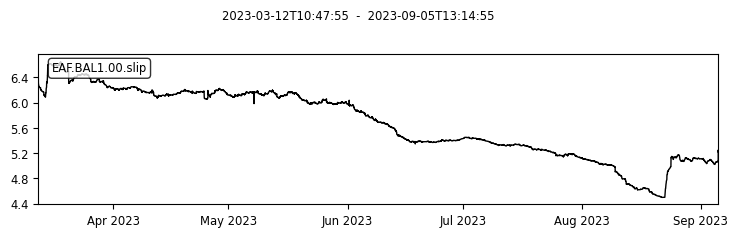

BIT1 2
no author
no file found
C461 3
PARK
['C461_10.0mins']
Key: C461_10.0mins
['Slip_C461_10mins', 'Time_C461_10mins']
C461_10T
2022-06-20T12:40:00.000000Z


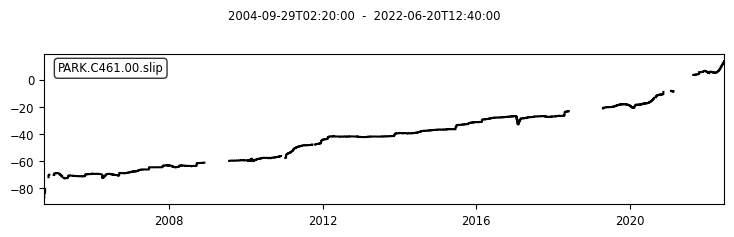

C462 4
PARK
['C462_1.0mins']
Key: C462_1.0mins
['Slip_C462_1mins', 'Time_C462_1mins']
C462_1T
2024-03-22T01:05:11.000000Z


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small',


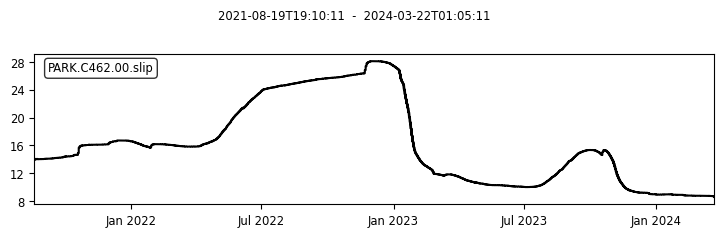

CAN1 5
UTA
['CAN1_30.0mins', 'Temperature']
Key: CAN1_30.0mins
['Slip_CAN1_30mins', 'Time_CAN1_30mins']
CAN1_30T
2017-06-15T08:33:00.000000Z


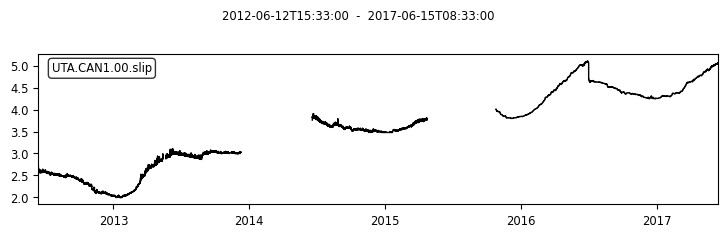

CER1 6
NAF
['CER1_0.5mins', 'CER1_1.0mins', 'Temperature']
Key: CER1_0.5mins
['Slip_CER1_30secs', 'Time_CER1_30secs']
CER1_30S
2024-05-23T10:25:30.000000Z


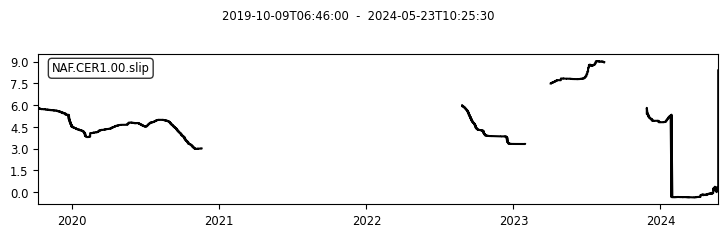

Key: CER1_1.0mins
['Slip_CER1_1mins', 'Time_CER1_1mins']
CER1_1T
2019-10-09T06:19:41.000000Z


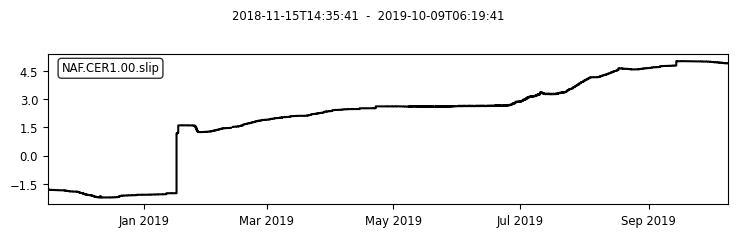

CFW1 7
HAY
['CFW1_1.0mins', 'CFW1_10.0mins', 'CFW1_60.0mins']
Key: CFW1_1.0mins
['Slip_CFW1_1.0mins', 'Time_CFW1_1.0mins']
CFW1_1T
2024-10-09T19:17:00.000000Z


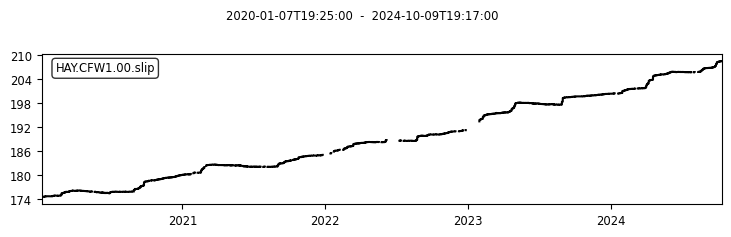

Key: CFW1_10.0mins
['Slip_CFW1_10.0mins', 'Time_CFW1_10.0mins']
CFW1_10T
2020-01-07T19:09:59.000000Z


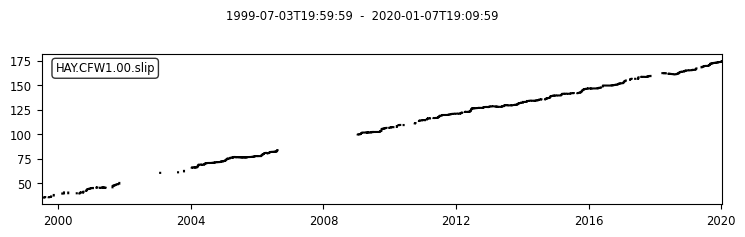

Key: CFW1_60.0mins
['Slip_CFW1_60.0mins', 'Time_CFW1_60.0mins']
CFW1_60T
1999-07-02T00:00:00.000000Z


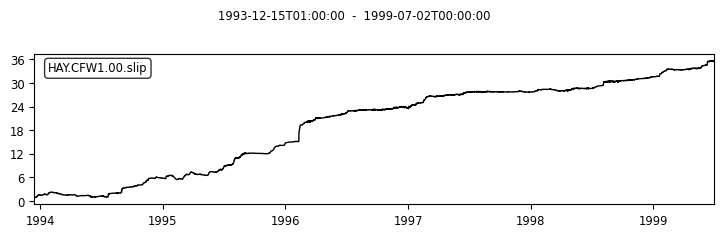

CHA1 8
CHAF
['CHA1_10.0mins']
Key: CHA1_10.0mins
['Slip_CHA1_10.0mins', 'Time_CHA1_10.0mins']
CHA1_10T
2020-11-21T13:37:23.000000Z


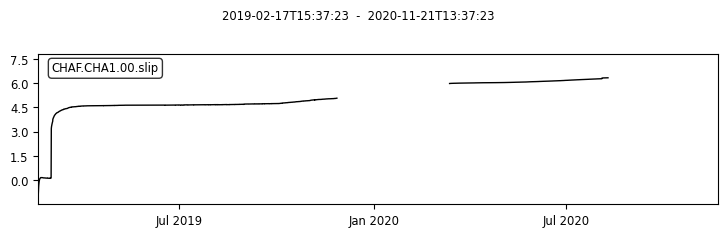

CHE1 9
NAF
['CHE1_0.5mins', 'CHE1_1.0mins', 'CHE1_5.0mins', 'Temperature']
Key: CHE1_0.5mins
['Slip_CHE1_0.5mins', 'Time_CHE1_0.5mins']
CHE1_30S
2020-05-01T17:52:26.000000Z


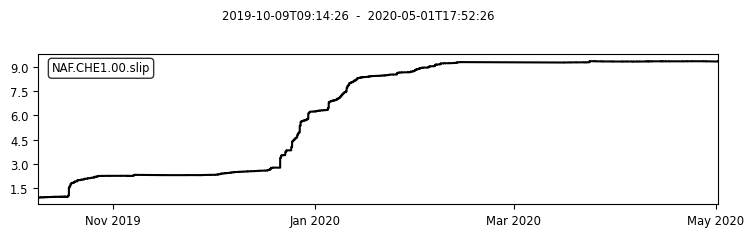

Key: CHE1_1.0mins
['Slip_CHE1_1.0mins', 'Time_CHE1_1.0mins']
CHE1_1T
2019-10-08T13:39:00.000000Z


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small',


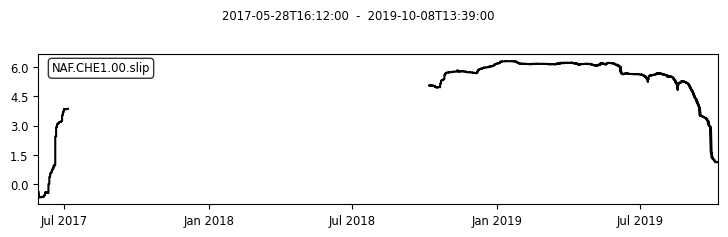

Key: CHE1_5.0mins
['Slip_CHE1_5.0mins', 'Time_CHE1_5.0mins']
CHE1_5T
2018-10-04T15:51:22.000000Z


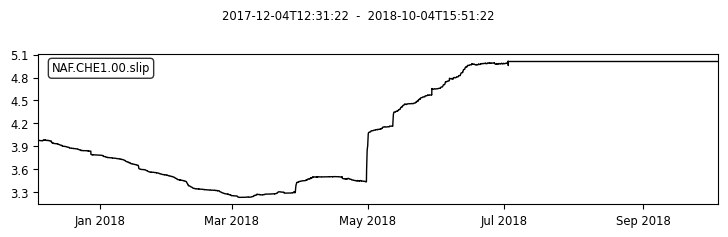

CHP1 10
HAY
['CHP1_1.0mins', 'CHP1_10.0mins']
Key: CHP1_1.0mins
['Slip_CHP1_1.0mins', 'Time_CHP1_1.0mins']
CHP1_1T
2024-10-09T19:08:59.000000Z


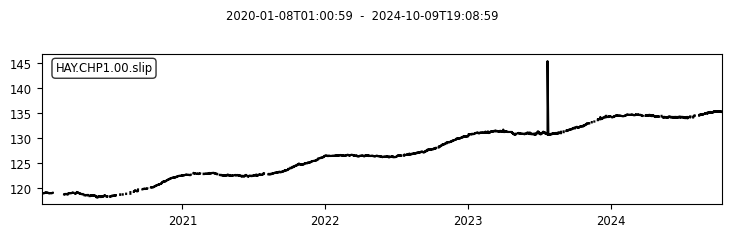

Key: CHP1_10.0mins
['Slip_CHP1_10.0mins', 'Time_CHP1_10.0mins']
CHP1_10T
2020-01-07T22:10:00.000000Z


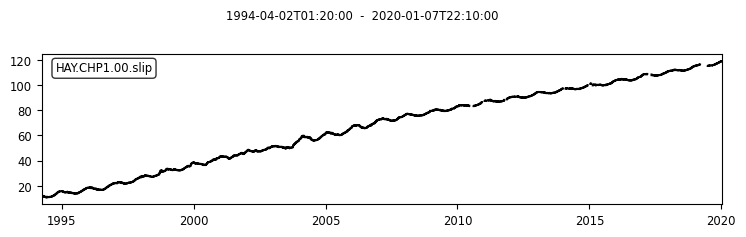

COZ1 11
HAY
['COZ1_1.0mins', 'COZ1_10.0mins', 'COZ1_60.0mins']
Key: COZ1_1.0mins
['Slip_COZ1_1.0mins', 'Time_COZ1_1.0mins']
COZ1_1T
2024-10-09T19:07:00.000000Z


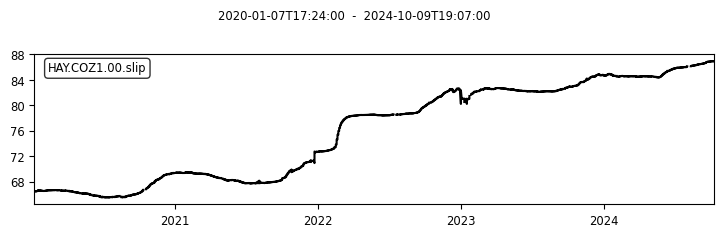

Key: COZ1_10.0mins
['Slip_COZ1_10.0mins', 'Time_COZ1_10.0mins']
COZ1_10T
2020-01-07T17:10:00.000000Z


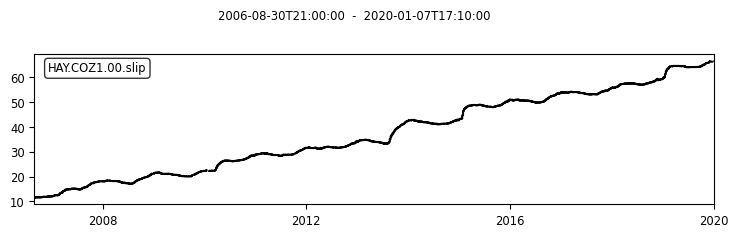

Key: COZ1_60.0mins
['Slip_COZ1_60.0mins', 'Time_COZ1_60.0mins']
COZ1_60T
2006-08-30T20:00:00.000000Z


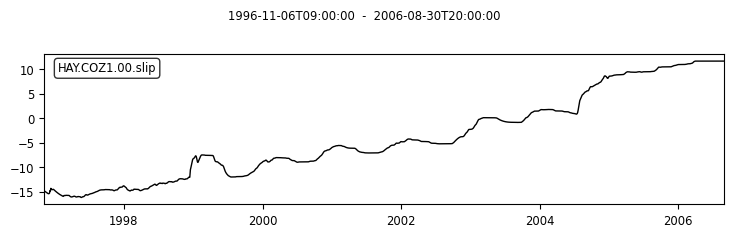

CPP1 12
HAY
['CPP1_1.0mins', 'CPP1_10.0mins']
Key: CPP1_1.0mins
['Slip_CPP1_1.0mins', 'Time_CPP1_1.0mins']
CPP1_1T
2024-06-26T23:59:00.000000Z


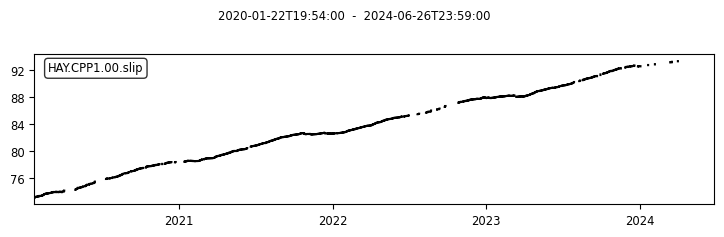

Key: CPP1_10.0mins
['Slip_CPP1_10.0mins', 'Time_CPP1_10.0mins']
CPP1_10T
2024-10-09T18:09:59.000000Z


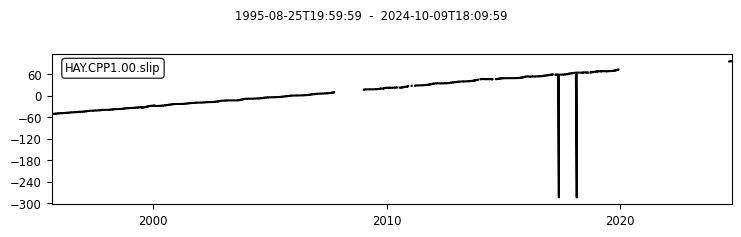

CRR1 13
PARK
['CRR1_10.0mins', 'Daily_measurements', 'Manual_measurements']
Key: CRR1_10.0mins
['Slip_CRR1_10.0mins', 'Time_CRR1_10.0mins']
CRR1_10T
2017-03-27T09:50:00.000000Z


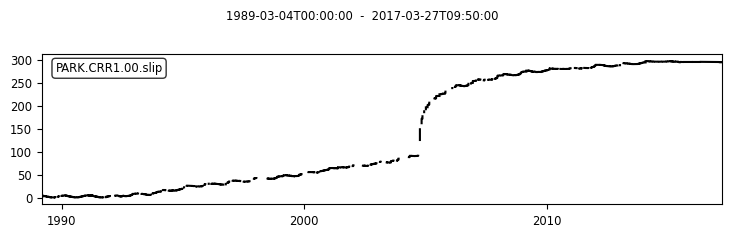

CTM1 14
HAY
['CTM1_1.0mins', 'CTM1_10.0mins', 'CTM1_60.0mins']
Key: CTM1_1.0mins
['Slip_CTM1_1.0mins', 'Time_CTM1_1.0mins']
CTM1_1T
2024-10-09T18:58:00.000000Z


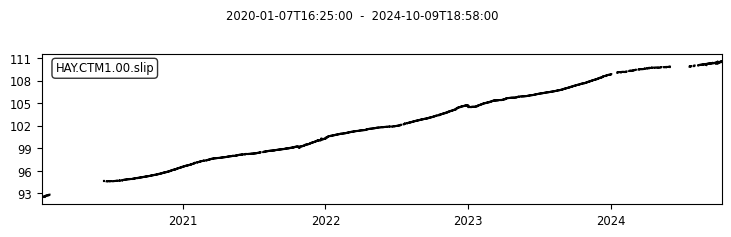

Key: CTM1_10.0mins
['Slip_CTM1_10.0mins', 'Time_CTM1_10.0mins']
CTM1_10T
2020-01-07T16:19:59.000000Z


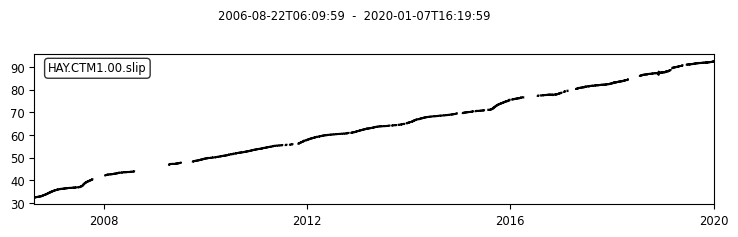

Key: CTM1_60.0mins
['Slip_CTM1_60.0mins', 'Time_CTM1_60.0mins']
CTM1_60T
2006-08-22T00:00:00.000000Z


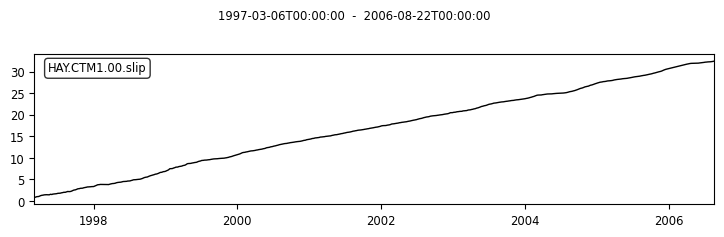

CWC3 15
HOL
['CWC3_10.0mins', 'Daily_measurements', 'Manual_measurements']
Key: CWC3_10.0mins
['Slip_CWC3_10.0mins', 'Time_CWC3_10.0mins']
CWC3_10T
2000-12-11T00:00:00.000000Z


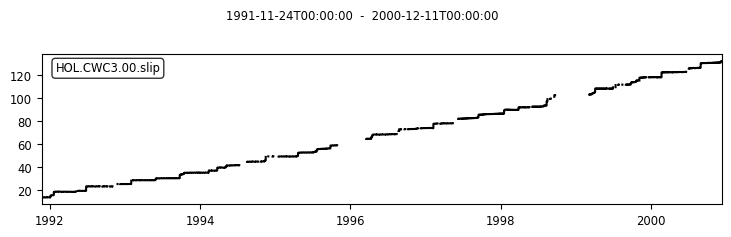

CWN1 16
HOL
['CWN1_1.0mins', 'CWN1_10.0mins', 'CWN1_2.0mins', 'Daily_measurements', 'Manual_measurements']
Key: CWN1_1.0mins
['Slip_CWN1_1.0mins', 'Time_CWN1_1.0mins']
CWN1_1T
2023-12-15T13:00:00.000000Z


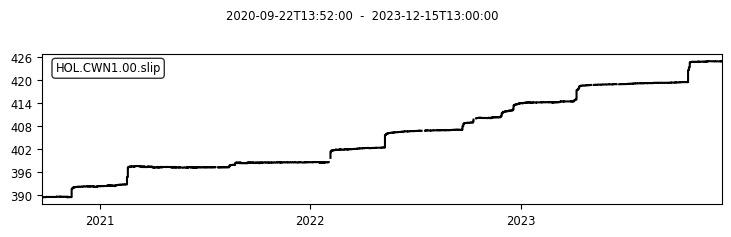

Key: CWN1_10.0mins
['Slip_CWN1_10.0mins', 'Time_CWN1_10.0mins']
CWN1_10T
2020-09-03T19:30:00.000000Z


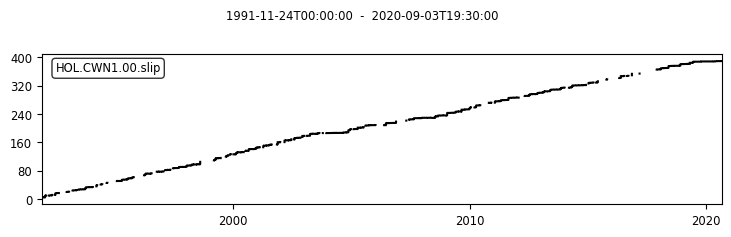

Key: CWN1_2.0mins
['Slip_CWN1_2.0mins', 'Time_CWN1_2.0mins']
CWN1_2T
2020-09-22T13:50:00.000000Z


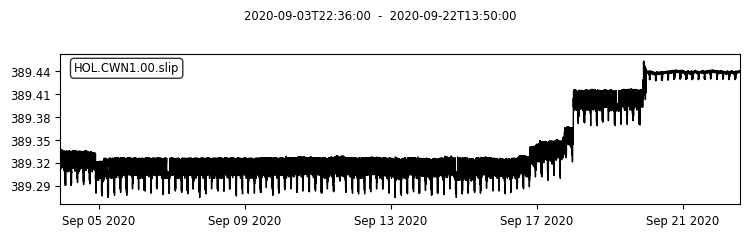

DS30 17
DSF
['DS30_60.0mins', 'Orthogonal', 'Temperature']
Key: DS30_60.0mins
['Slip_DS30_60.0mins', 'Time_DS30_60.0mins']
DS30_60T
2024-05-05T00:00:00.000000Z


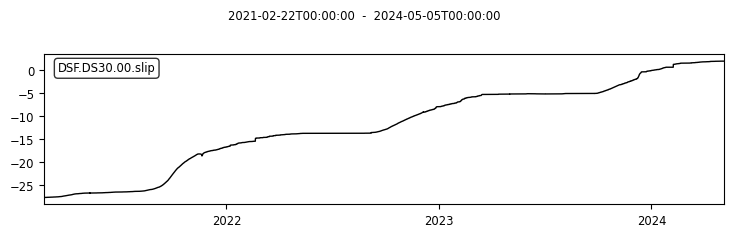

DU30 18
SOCAL
['DU30_1.0mins', 'DU30_10.0mins', 'DU30_30.0mins', 'DU30_5.0mins']
Key: DU30_1.0mins
['Slip_DU30_1.0mins', 'Time_DU30_1.0mins']
DU30_1T
2024-02-02T20:29:00.000000Z


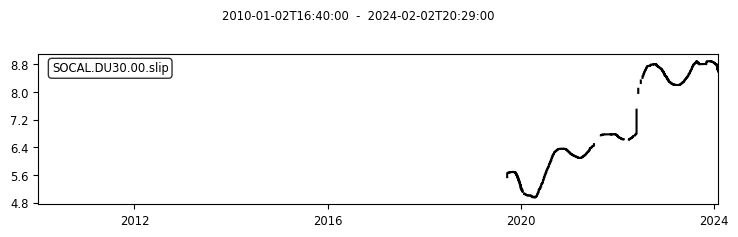

Key: DU30_10.0mins
['Slip_DU30_10.0mins', 'Time_DU30_10.0mins']
DU30_10T
2010-01-02T16:20:00.000000Z


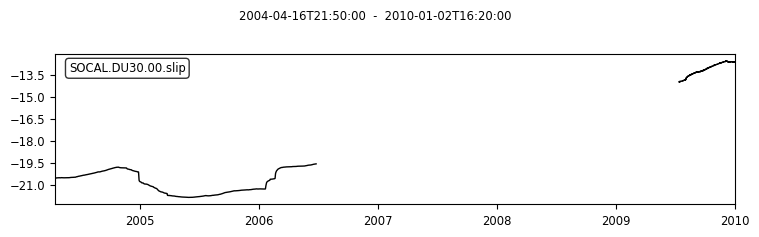

Key: DU30_30.0mins
['Slip_DU30_30.0mins', 'Time_DU30_30.0mins']
DU30_30T
2019-09-10T08:53:49.000000Z


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small',


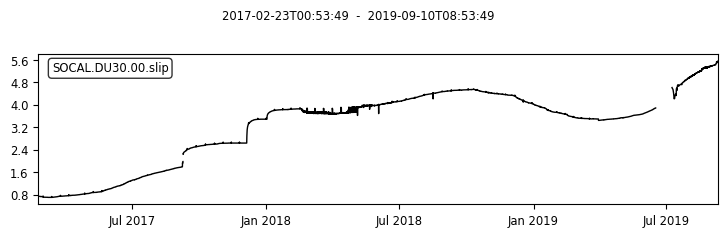

Key: DU30_5.0mins
['Slip_DU30_5.0mins', 'Time_DU30_5.0mins']
DU30_5T
2017-02-23T00:00:00.000000Z


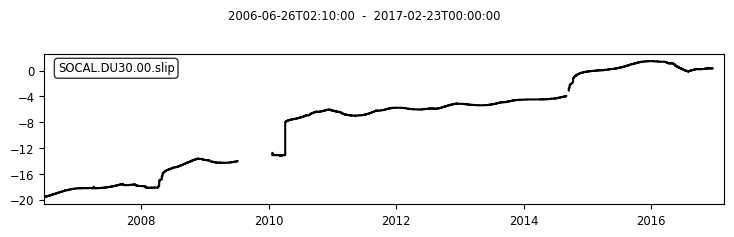

ESZ1 19
NAF
['ESZ1_1.0mins', 'ESZ1_5.0mins', 'Temperature']
Key: ESZ1_1.0mins
['Slip_ESZ1_1.0mins', 'Time_ESZ1_1.0mins']
ESZ1_1T
2022-04-19T19:31:26.000000Z


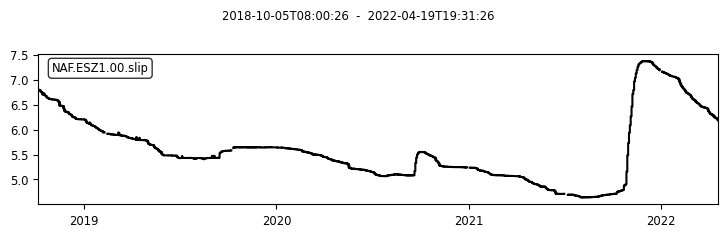

Key: ESZ1_5.0mins
['Slip_ESZ1_5.0mins', 'Time_ESZ1_5.0mins']
ESZ1_5T
2018-10-05T06:13:27.000000Z


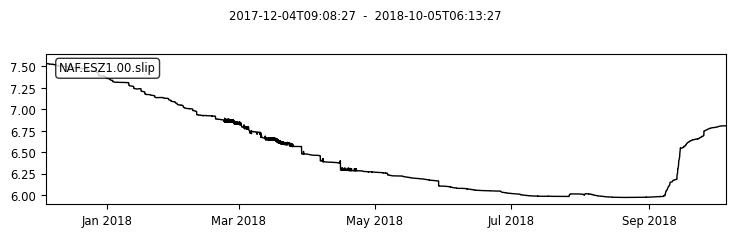

FCR1 20
HOL
['FCR1_1.0mins', 'Orthogonal', 'Temperature']
Key: FCR1_1.0mins
['Slip_FCR1_1.0mins', 'Time_FCR1_1.0mins']
FCR1_1T
2024-03-03T20:03:00.000000Z


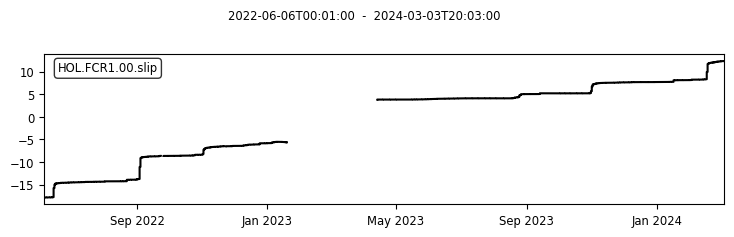

FE30 21
SOCAL
['FE30_10.0mins', 'FE30_15.0mins', 'FE30_30.0mins', 'FE30_5.0mins', 'Temperature']
Key: FE30_10.0mins
['Slip_FE30_10.0mins', 'Time_FE30_10.0mins']
FE30_10T
2008-07-30T01:40:00.000000Z


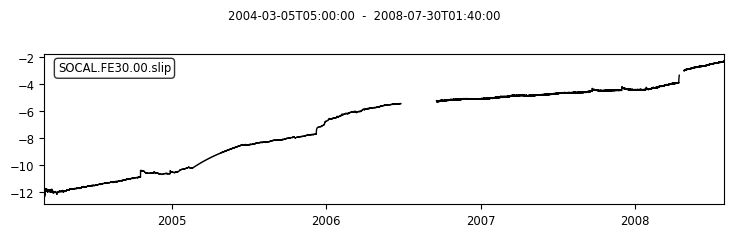

Key: FE30_15.0mins
['Slip_FE30_15.0mins', 'Time_FE30_15.0mins']
FE30_15T
2010-06-04T14:16:00.000000Z


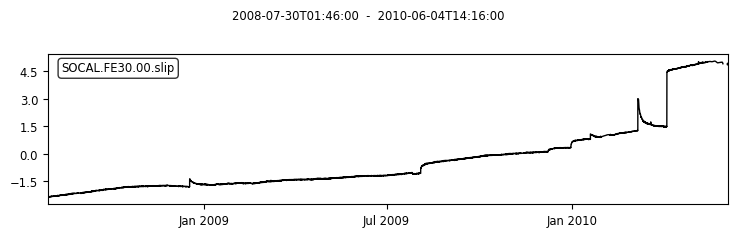

Key: FE30_30.0mins
['Slip_FE30_30.0mins', 'Time_FE30_30.0mins']
FE30_30T
2019-08-12T19:00:00.000000Z


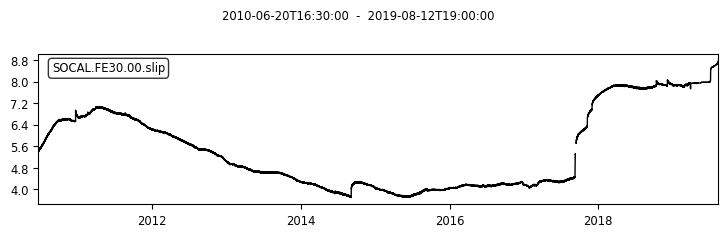

Key: FE30_5.0mins
['Slip_FE30_5.0mins', 'Time_FE30_5.0mins']
FE30_5T
2006-09-12T03:29:00.000000Z


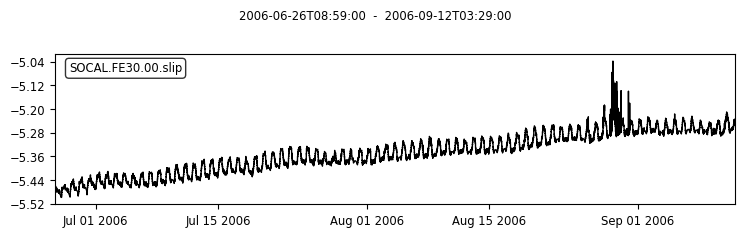

GB 22
RID
['GB_10.0mins', 'GB_10s']
Key: GB_10.0mins
['Slip_GB_10.0mins', 'Time_GB_10.0mins']
GB_10T
2019-09-06T07:40:00.000000Z


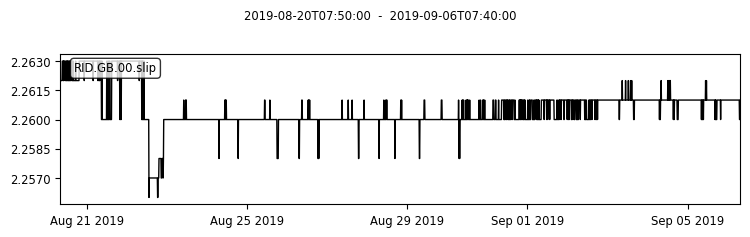

Key: GB_10s
['Slip_GB_10s', 'Time_GB_10s']
GB_10S
2019-08-19T00:15:58.000000Z


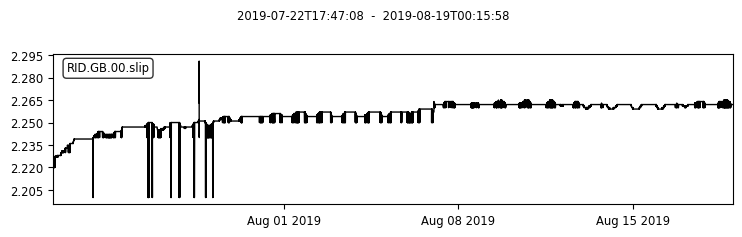

GD 23
RID
['GD_1.0mins', 'GD_5.0mins']
Key: GD_1.0mins
['Slip_GD_1.0mins', 'Time_GD_1.0mins']
GD_1T
2020-03-01T23:00:22.000000Z


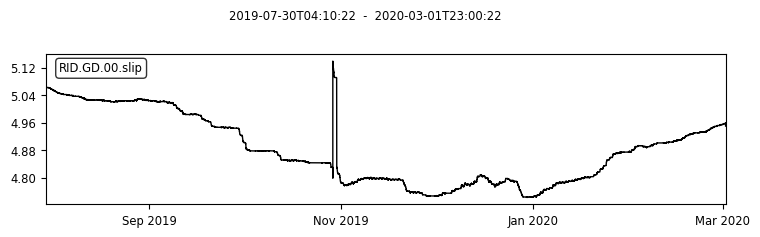

Key: GD_5.0mins
['Slip_GD_5.0mins', 'Time_GD_5.0mins']
GD_5T
2024-08-28T18:27:05.000000Z


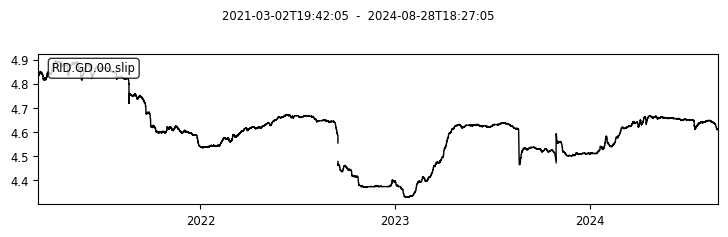

GOK1 24
EAF
['GOK1_1.0mins', 'Orthogonal', 'Temperature']
Key: GOK1_1.0mins
['Slip_GOK1_1.0mins', 'Time_GOK1_1.0mins']
GOK1_1T
2024-05-25T04:33:00.000000Z


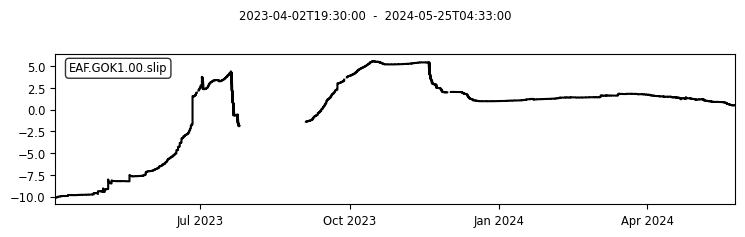

GOZ1 25
EAF
['GOZ1_1.0mins', 'Temperature']
Key: GOZ1_1.0mins
['Slip_GOZ1_1.0mins', 'Time_GOZ1_1.0mins']
GOZ1_1T
2024-05-25T15:44:00.000000Z


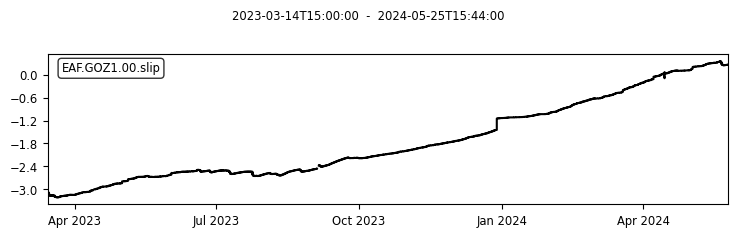

GS 26
RID
['GS_1.0mins', 'GS_10.0mins', 'GS_10s']
Key: GS_1.0mins
['Slip_GS_1.0mins', 'Time_GS_1.0mins']
GS_1T
2019-08-19T13:34:12.000000Z


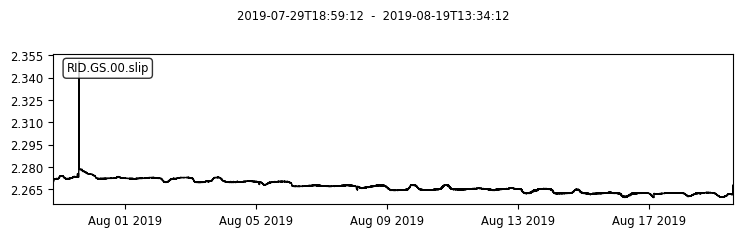

Key: GS_10.0mins
['Slip_GS_10.0mins', 'Time_GS_10.0mins']
GS_10T
2019-10-01T07:20:00.000000Z


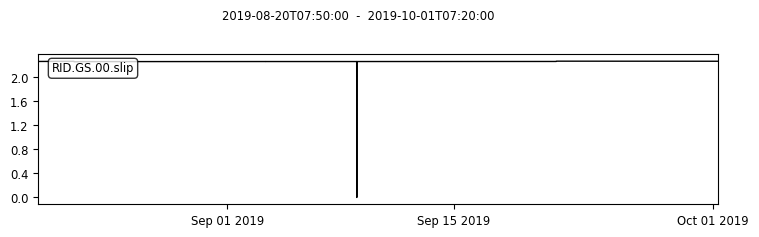

Key: GS_10s
['Slip_GS_10s', 'Time_GS_10s']
GS_10S
2019-07-29T18:22:03.000000Z


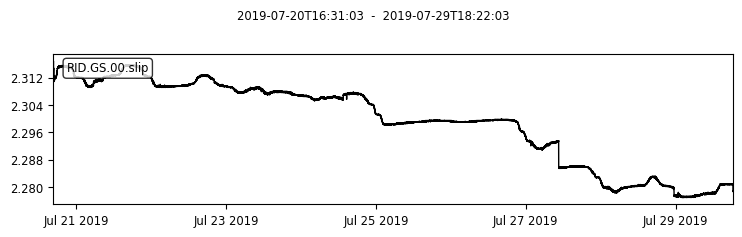

HAM1 27
NAF
['HAM1_1.0mins']
Key: HAM1_1.0mins
['Slip_HAM1_1.0mins', 'Time_HAM1_1.0mins']
HAM1_1T
2020-01-20T14:39:42.000000Z


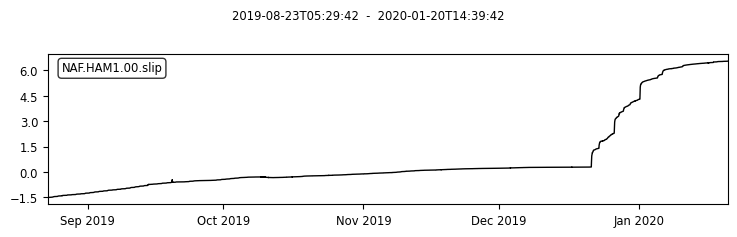

HAS1 28
EAF
['HAS1_1.0mins']
Key: HAS1_1.0mins
['Slip_HAS1_1.0mins', 'Time_HAS1_1.0mins']
HAS1_1T
2023-08-22T11:03:00.000000Z


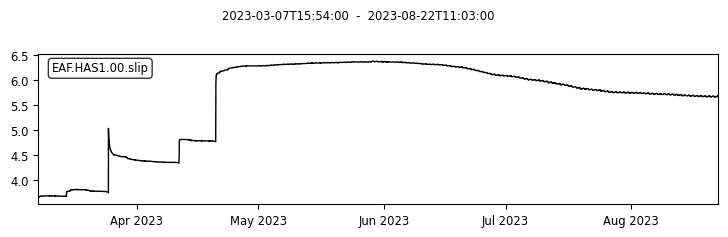

HAT1 29
EAF
['HAT1_1.0mins']
Key: HAT1_1.0mins
['Slip_HAT1_1.0mins', 'Time_HAT1_1.0mins']
HAT1_1T
2023-10-20T22:35:00.000000Z


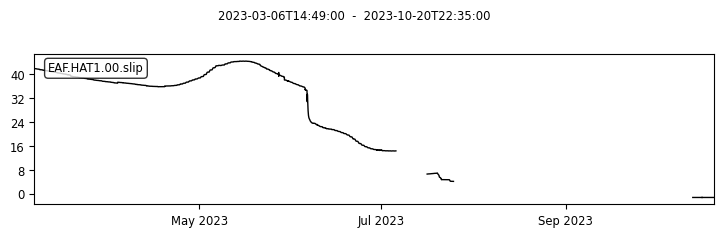

HLC1 30
no author
no file found
HLD1 31
no author
no file found
HWE1 32
no author
no file found
HWP1 33
no author
no file found
HWR1 34
no author
no file found
HWR2 35
no author
no file found
HWW1 36
no author
no file found
INW1 37
NAF
['INW1_1.0mins', 'INW1_30.0mins']
Key: INW1_1.0mins
['Slip_INW1_1.0mins', 'Time_INW1_1.0mins']
INW1_1T
2023-09-16T10:12:00.000000Z


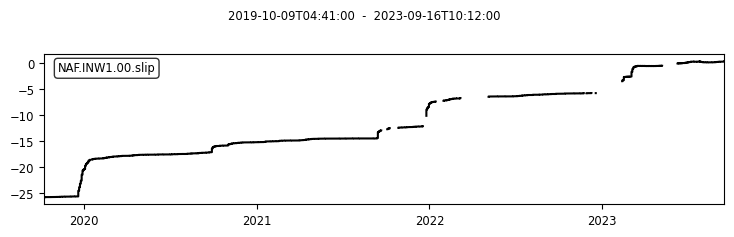

Key: INW1_30.0mins
['Slip_INW1_30.0mins', 'Time_INW1_30.0mins']
INW1_30T
2019-10-08T09:30:00.000000Z


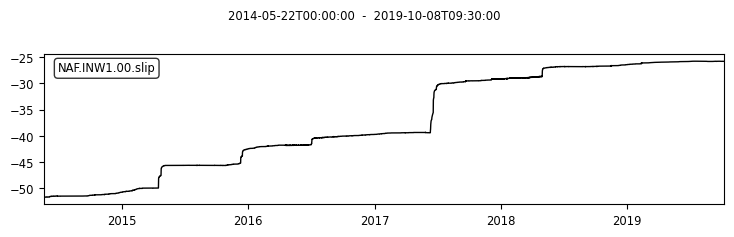

IR30 38
SOCAL
['IR30_1.0mins', 'IR30_5.0mins', 'Temperature']
Key: IR30_1.0mins
['Slip_IR30_1.0mins', 'Time_IR30_1.0mins']
IR30_1T
2024-11-27T18:00:00.000000Z


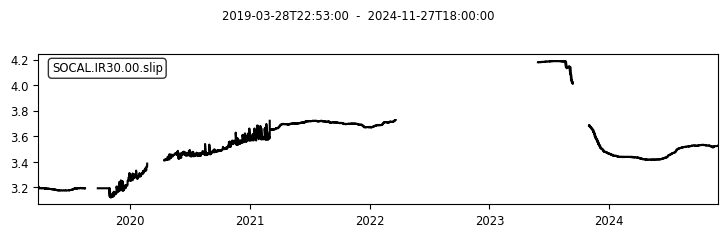

Key: IR30_5.0mins
['Slip_IR30_5.0mins', 'Time_IR30_5.0mins']
IR30_5T
2019-03-28T21:57:31.000000Z


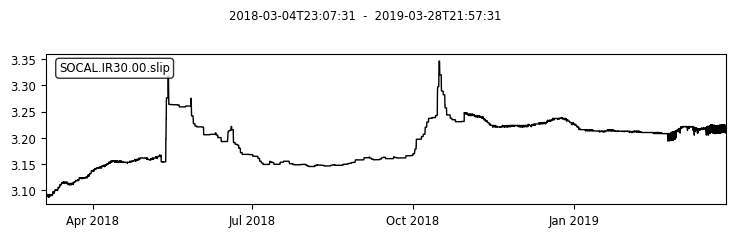

ISW1 39
NAF
['ISW1_1.0mins']
Key: ISW1_1.0mins
['Slip_ISW1_1.0mins', 'Time_ISW1_1.0mins']
ISW1_1T
2024-09-26T22:19:55.000000Z


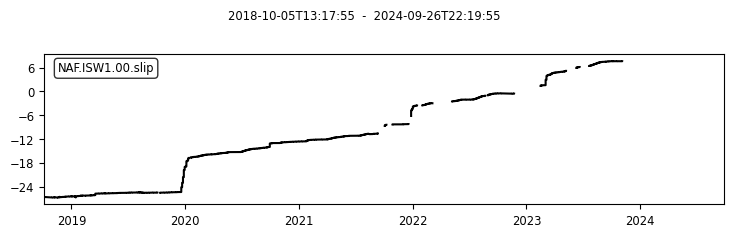

KAR1 40
EAF
['KAR1_1.0mins', 'Orthogonal', 'Temperature']
Key: KAR1_1.0mins
['Slip_KAR1_1.0mins', 'Time_KAR1_1.0mins']
KAR1_1T
2024-05-26T06:49:00.000000Z


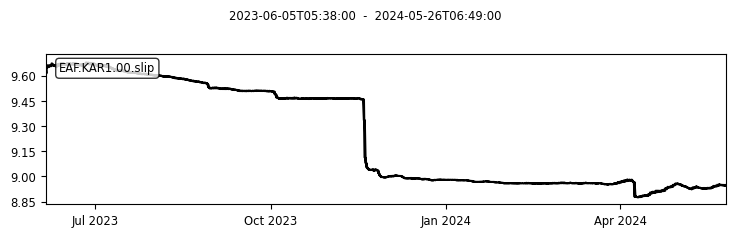

KIR1 41
EAF
['KIR1_1.0mins', 'Temperature']
Key: KIR1_1.0mins
['Slip_KIR1_1.0mins', 'Time_KIR1_1.0mins']
KIR1_1T
2024-05-25T08:55:00.000000Z


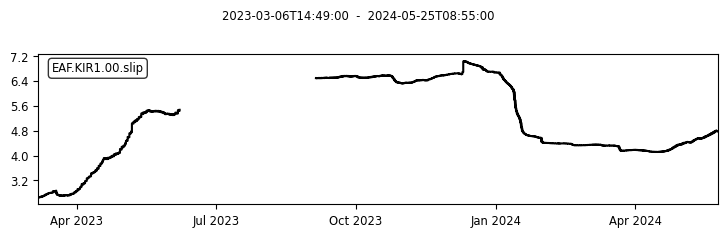

MRW1 42
no author
no file found
NS45 43
SOCAL
['NS45_1.0mins', 'NS45_10.0mins', 'NS45_30.0mins', 'NS45_5.0mins', 'Temperature']
Key: NS45_1.0mins
['Slip_NS45_1.0mins', 'Time_NS45_1.0mins']
NS45_1T
2022-06-15T12:51:06.000000Z


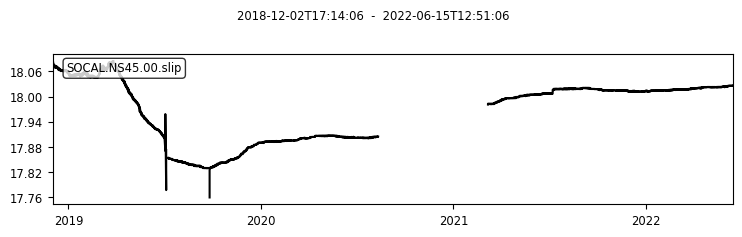

Key: NS45_10.0mins
['Slip_NS45_10.0mins', 'Time_NS45_10.0mins']
NS45_10T
2018-05-11T18:10:36.000000Z


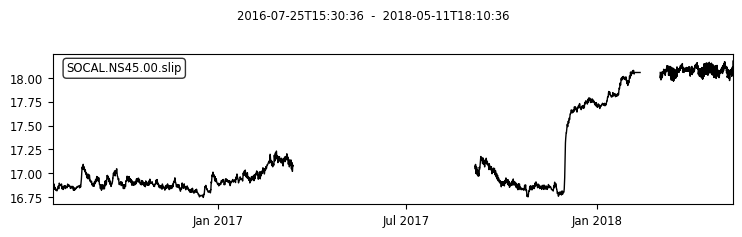

Key: NS45_30.0mins
['Slip_NS45_30.0mins', 'Time_NS45_30.0mins']
NS45_30T
2014-09-06T21:00:00.000000Z


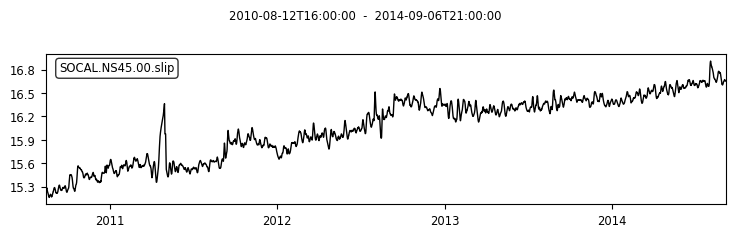

Key: NS45_5.0mins
['Slip_NS45_5.0mins', 'Time_NS45_5.0mins']
NS45_5T
2016-07-25T15:29:20.000000Z


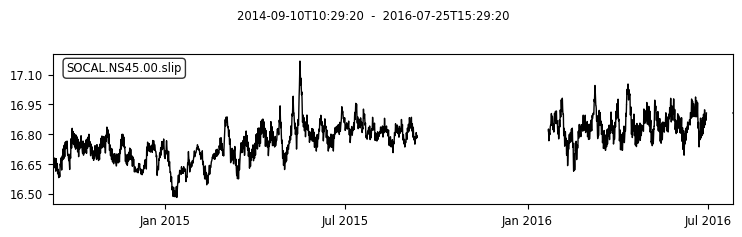

ORM1 44
EAF
['ORM1_1.0mins', 'Temperature']
Key: ORM1_1.0mins
['Slip_ORM1_1.0mins', 'Time_ORM1_1.0mins']
ORM1_1T
2023-12-02T08:37:00.000000Z


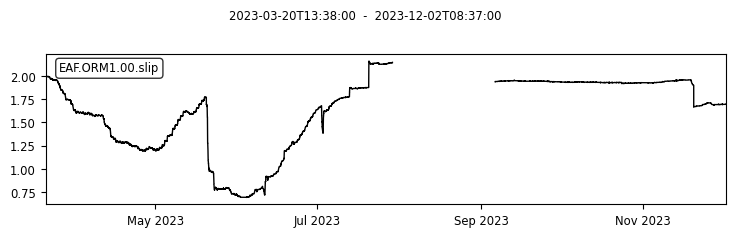

PAN1 45
EAF
['PAN1_1.0mins', 'PAN1_5.0mins', 'Temperature']
Key: PAN1_1.0mins
['Slip_PAN1_1.0mins', 'Time_PAN1_1.0mins']
PAN1_1T
2024-05-27T09:20:44.000000Z


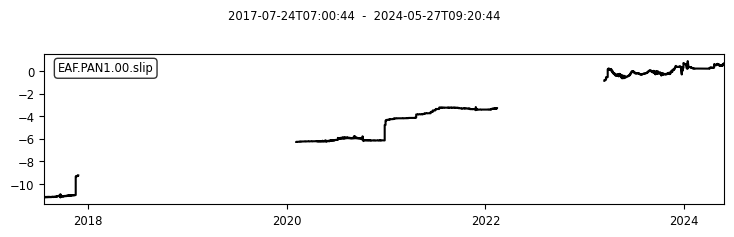

Key: PAN1_5.0mins
['Slip_PAN1_5.0mins', 'Time_PAN1_5.0mins']
PAN1_5T
2020-02-02T09:13:13.000000Z


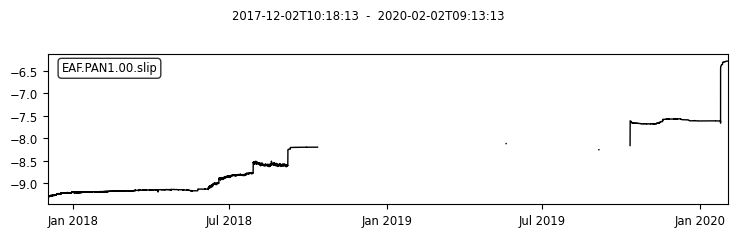

PAS1 46
EAF
['PAS1_1.0mins', 'PAS1_5.0mins', 'Temperature']
Key: PAS1_1.0mins
['Slip_PAS1_1.0mins', 'Time_PAS1_1.0mins']
PAS1_1T
2021-11-26T19:31:44.000000Z


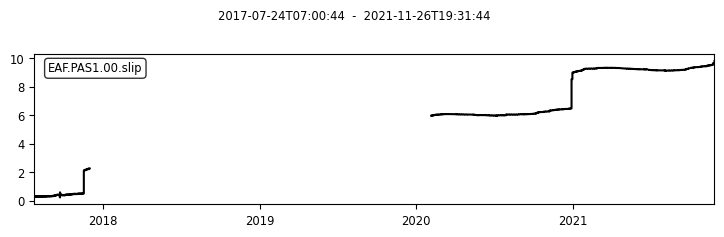

Key: PAS1_5.0mins
['Slip_PAS1_5.0mins', 'Time_PAS1_5.0mins']
PAS1_5T
2020-02-02T09:10:12.000000Z


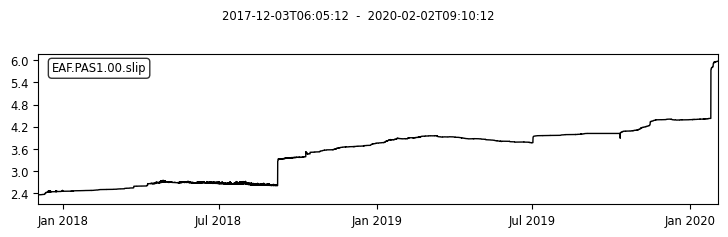

PET1 47
NAF
['PET1_1.0mins', 'PET1_30.0mins']
Key: PET1_1.0mins
['Slip_PET1_1.0mins', 'Time_PET1_1.0mins']
PET1_1T
2019-10-09T10:15:45.000000Z


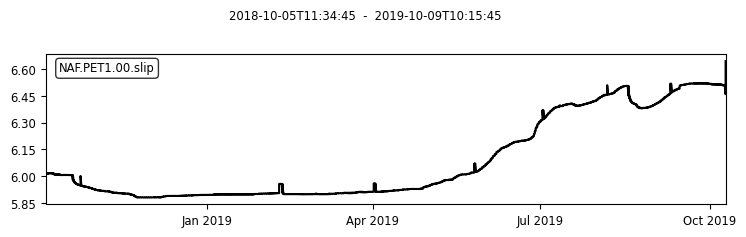

Key: PET1_30.0mins
['Slip_PET1_30.0mins', 'Time_PET1_30.0mins']
PET1_30T
2018-10-05T08:23:57.000000Z


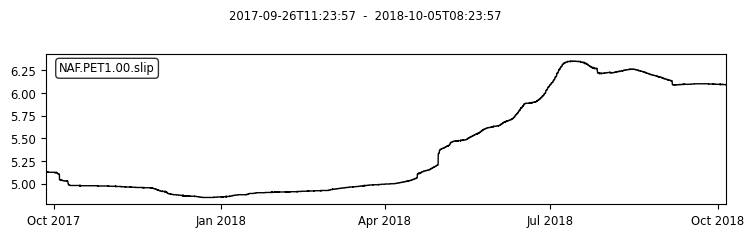

QE30 48
SOCAL
['QE30_1.0mins', 'Temperature']
Key: QE30_1.0mins
['Slip_QE30_1.0mins', 'Time_QE30_1.0mins']
QE30_1T
2024-03-20T14:37:52.000000Z


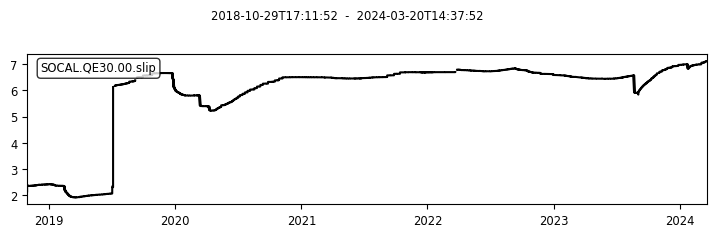

QW30 49
SOCAL
['QW30_1.0mins', 'Temperature']
Key: QW30_1.0mins
['Slip_QW30_1.0mins', 'Time_QW30_1.0mins']
QW30_1T
2019-10-27T16:29:00.000000Z


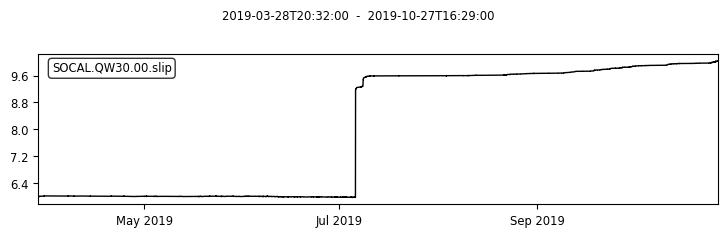

R7 50
RID
['R7_1.0mins', 'R7_10s']
Key: R7_1.0mins
['Slip_R7_1.0mins', 'Time_R7_1.0mins']
R7_1T
2019-09-05T14:37:27.000000Z


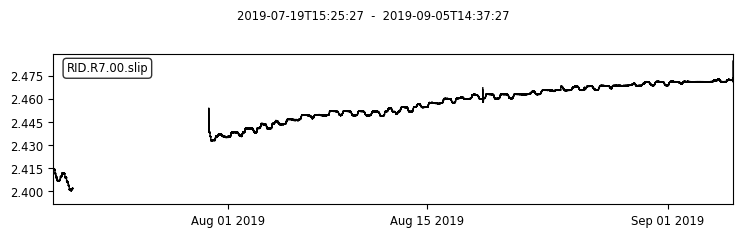

Key: R7_10s
['Slip_R7_10s', 'Time_R7_10s']
R7_10S
2019-07-30T15:10:25.000000Z


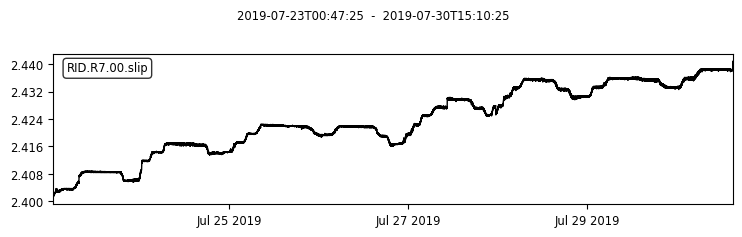

RA 51
RID
['RA_1.0mins', 'RA_10s']
Key: RA_1.0mins
['Slip_RA_1.0mins', 'Time_RA_1.0mins']
RA_1T
2019-09-05T15:19:20.000000Z


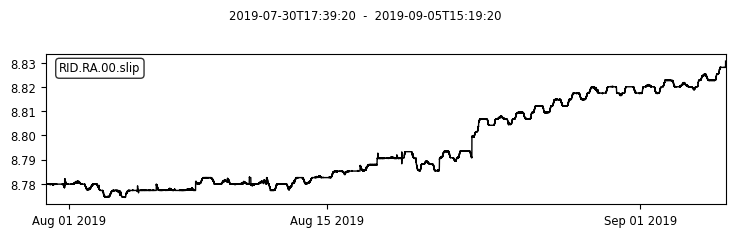

Key: RA_10s
['Slip_RA_10s', 'Time_RA_10s']
RA_10S
2019-07-30T17:37:51.000000Z


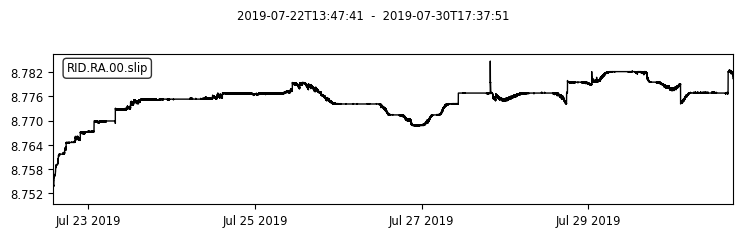

RB 52
RID
['RB_1.0mins', 'RB_10s']
Key: RB_1.0mins
['Slip_RB_1.0mins', 'Time_RB_1.0mins']
RB_1T
2019-09-05T15:35:18.000000Z


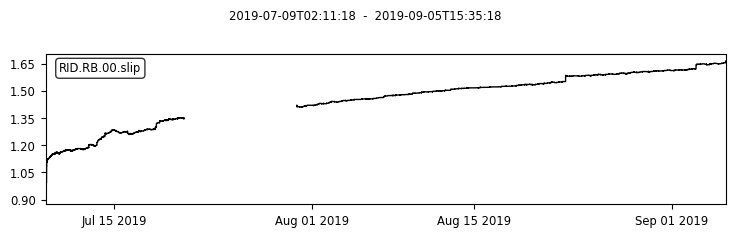

Key: RB_10s
['Slip_RB_10s', 'Time_RB_10s']
RB_10S
2019-07-30T17:33:07.000000Z


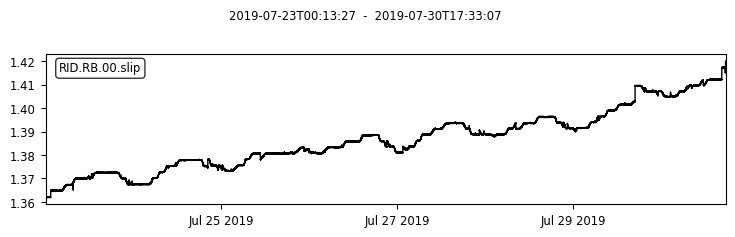

RR45 53
SOCAL
['RR45_1.0mins', 'RR45_10.0mins', 'RR45_30.0mins', 'RR45_5.0mins', 'Temperature']
Key: RR45_1.0mins
['Slip_RR45_1.0mins', 'Time_RR45_1.0mins']
RR45_1T
2023-10-07T11:08:46.000000Z


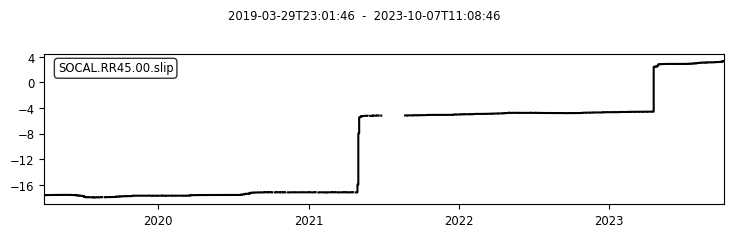

Key: RR45_10.0mins
['Slip_RR45_10.0mins', 'Time_RR45_10.0mins']
RR45_10T
2016-12-26T18:01:10.000000Z


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small',


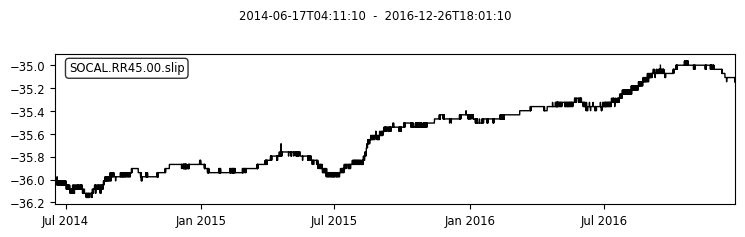

Key: RR45_30.0mins
['Slip_RR45_30.0mins', 'Time_RR45_30.0mins']
RR45_30T
2014-06-16T21:25:22.000000Z


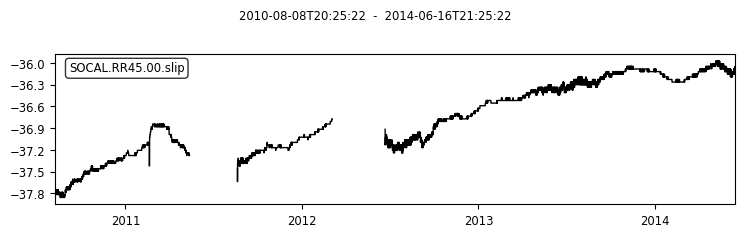

Key: RR45_5.0mins
['Slip_RR45_5.0mins', 'Time_RR45_5.0mins']
RR45_5T
2019-03-29T22:59:49.000000Z


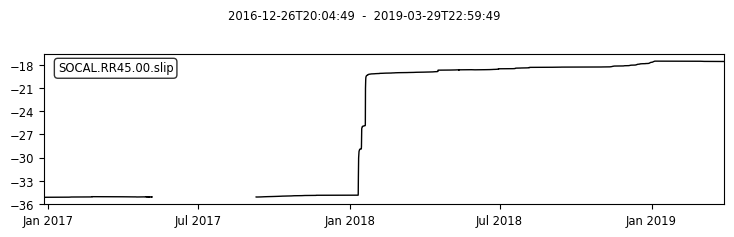

SEL1 54
NAF
['SEL1_0.5mins']
Key: SEL1_0.5mins
['Slip_SEL1_0.5mins', 'Time_SEL1_0.5mins']
SEL1_30S
2020-02-11T10:05:09.000000Z


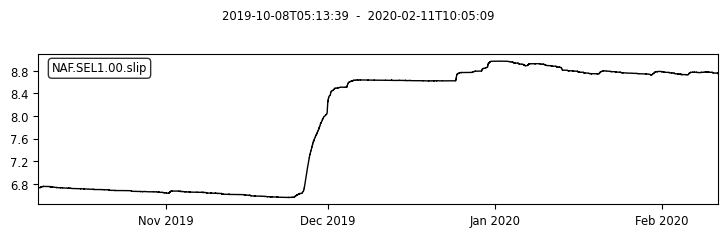

SH30 55
SOCAL
['Orthogonal_1T', 'Orthogonal_5T', 'SH30_1.0mins', 'SH30_5.0mins', 'Temperature_1T', 'Temperature_5T']
Key: Orthogonal_1T
['Slip_SH30_1_mins_Orthogonal', 'Time_SH30_1_mins_Orthogonal']
SH30_1T
2019-06-12T11:59:39.000000Z


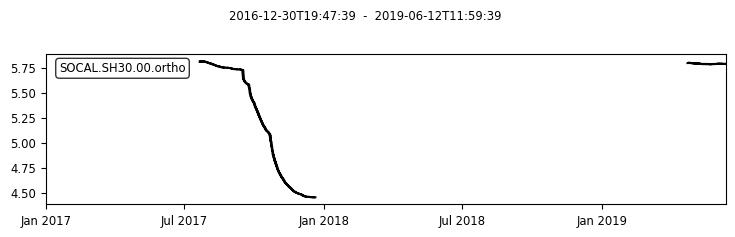

Key: Orthogonal_5T
['Slip_SH30_5_mins_Orthogonal', 'Time_SH30_5_mins_Orthogonal']
SH30_5T
2024-11-27T19:32:39.000000Z


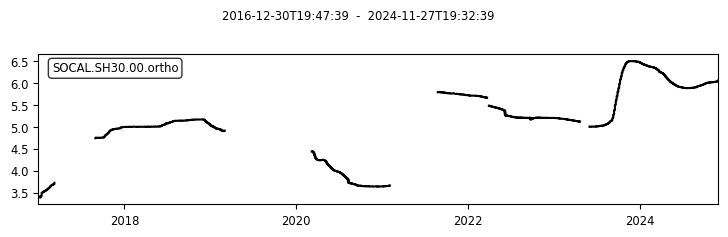

Key: SH30_1.0mins
['Slip_SH30_1.0mins', 'Time_SH30_1.0mins']
SH30_1T
2021-08-20T15:16:00.000000Z


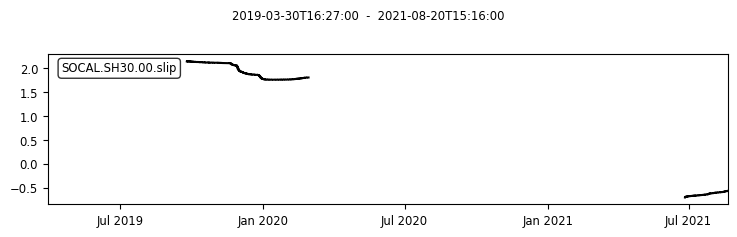

Key: SH30_5.0mins
['Slip_SH30_5.0mins', 'Time_SH30_5.0mins']
SH30_5T
2024-11-27T19:32:39.000000Z


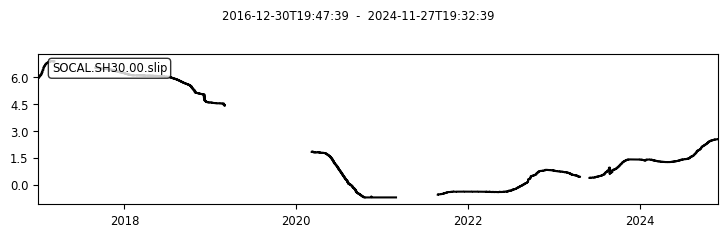

SHR2 56
no author
no file found
SIV1 57
EAF
['SIV1_1.0mins', 'SIV1_10s', 'Temperature']
Key: SIV1_1.0mins
['Slip_SIV1_1.0mins', 'Time_SIV1_1.0mins']
SIV1_1T
2024-05-27T05:52:27.000000Z


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small',


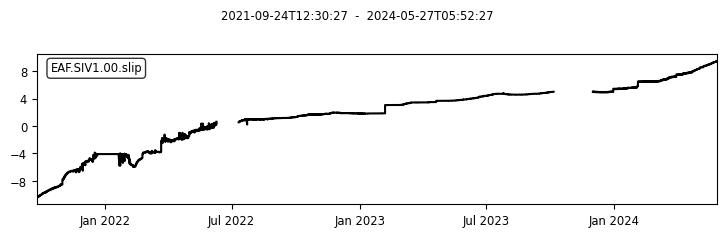

Key: SIV1_10s
['Slip_SIV1_10s', 'Time_SIV1_10s']
SIV1_10S
2021-09-24T12:26:41.000000Z


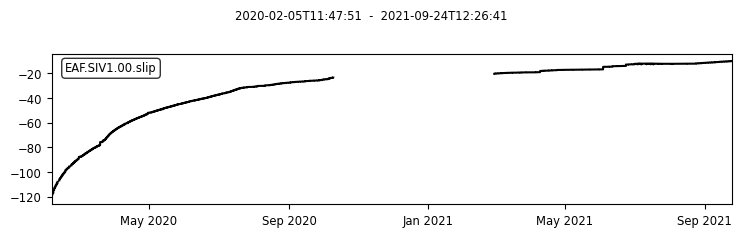

SJN1 58
HOL
['SJN1_1.0mins', 'SJN1_10.0mins', 'SJN1_30.0mins']
Key: SJN1_1.0mins
['Slip_SJN1_1.0mins', 'Time_SJN1_1.0mins']
SJN1_1T
2024-09-17T22:14:59.000000Z


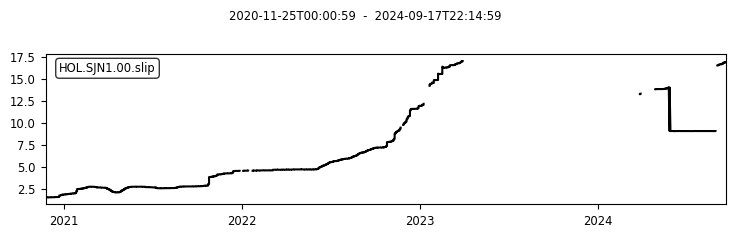

Key: SJN1_10.0mins
['Slip_SJN1_10.0mins', 'Time_SJN1_10.0mins']
SJN1_10T
2010-05-29T19:39:59.000000Z


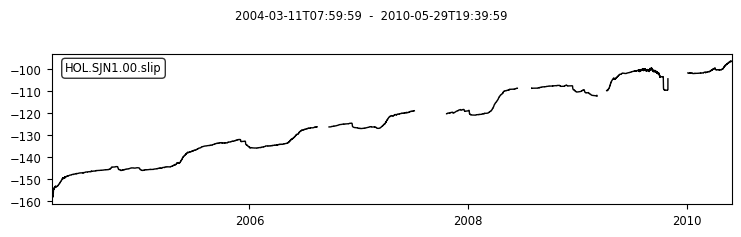

Key: SJN1_30.0mins
['Slip_SJN1_30.0mins', 'Time_SJN1_30.0mins']
SJN1_30T
2013-02-18T22:59:59.000000Z


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small',


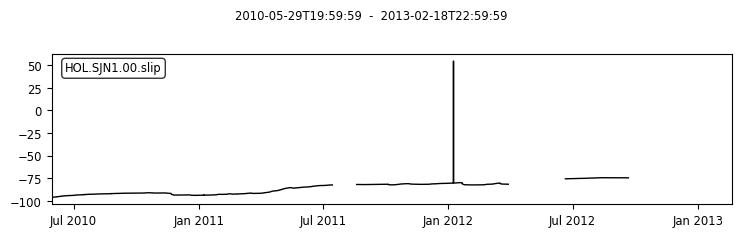

SU30 59
SOCAL
['SU30_1.0mins', 'SU30_10.0mins', 'SU30_15.0mins', 'SU30_2.0mins', 'SU30_5.0mins', 'Temperature']
Key: SU30_1.0mins
['Slip_SU30_1.0mins', 'Time_SU30_1.0mins']
SU30_1T
2023-10-07T02:32:54.000000Z


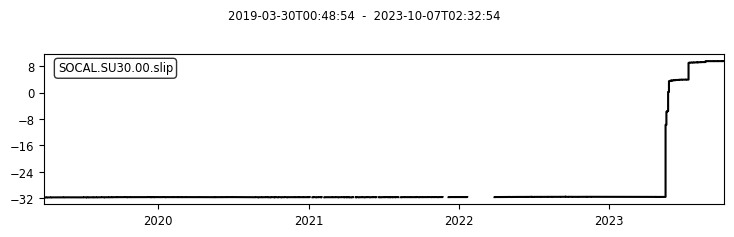

Key: SU30_10.0mins
['Slip_SU30_10.0mins', 'Time_SU30_10.0mins']
SU30_10T
2008-06-05T16:20:17.000000Z


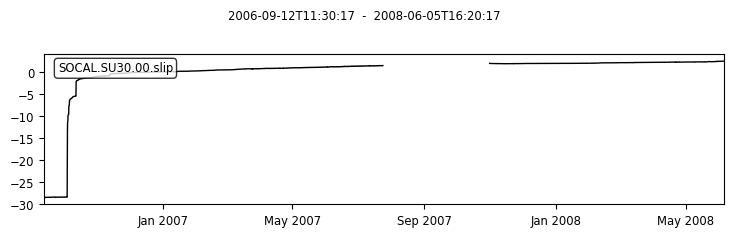

Key: SU30_15.0mins
['Slip_SU30_15.0mins', 'Time_SU30_15.0mins']
SU30_15T
2010-04-16T20:05:00.000000Z


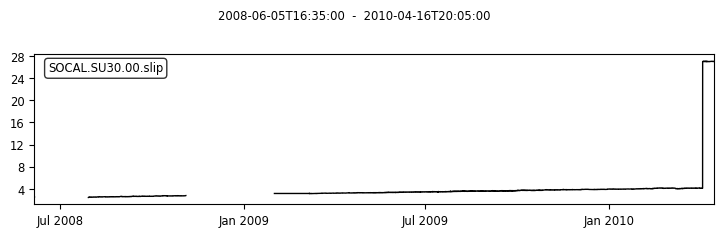

Key: SU30_2.0mins
['Slip_SU30_2.0mins', 'Time_SU30_2.0mins']
SU30_2T
2004-04-16T16:29:23.000000Z


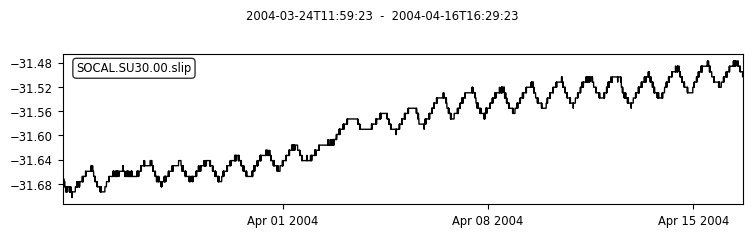

Key: SU30_5.0mins
['Slip_SU30_5.0mins', 'Time_SU30_5.0mins']
SU30_5T
2018-06-21T07:56:23.000000Z


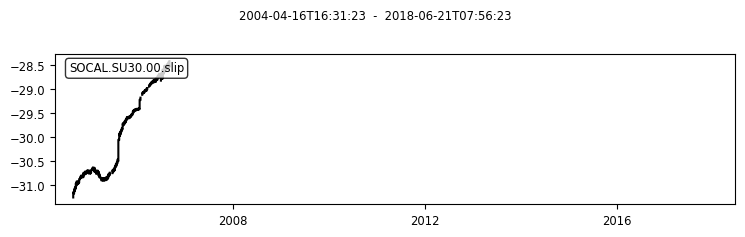

TABC 60
PARK
['Daily_measurements', 'Manual_measurements', 'TABC_10.0mins']
Key: TABC_10.0mins
['Slip_TABC_10.0mins', 'Time_TABC_10.0mins']
TABC_10T
2013-07-10T00:00:00.000000Z


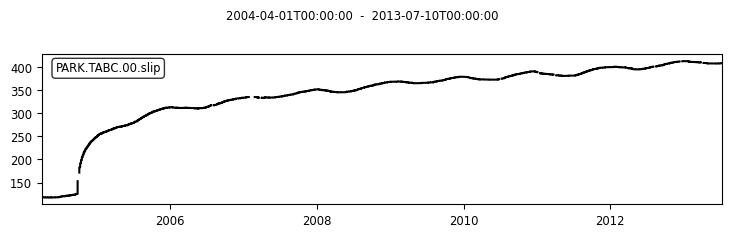

TAS1 61
EAF
['TAS1_1.0mins', 'TAS1_10.0mins', 'Temperature']
Key: TAS1_1.0mins
['Slip_TAS1_1.0mins', 'Time_TAS1_1.0mins']
TAS1_1T
2024-05-26T09:07:00.000000Z


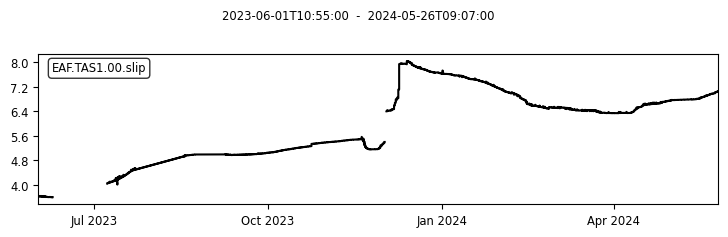

Key: TAS1_10.0mins
['Slip_TAS1_10.0mins', 'Time_TAS1_10.0mins']
TAS1_10T
2024-09-27T00:18:00.000000Z


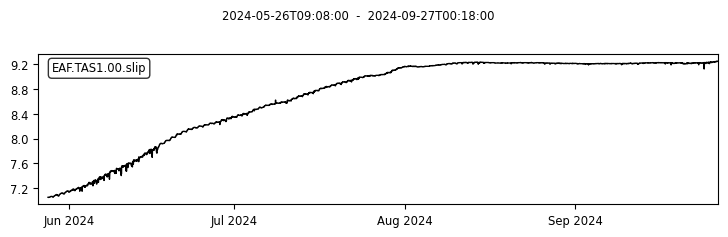

TEP1 62
NAF
['TEP1_0.5mins']
Key: TEP1_0.5mins
['Slip_TEP1_0.5mins', 'Time_TEP1_0.5mins']
TEP1_30S
2020-02-11T09:12:27.000000Z


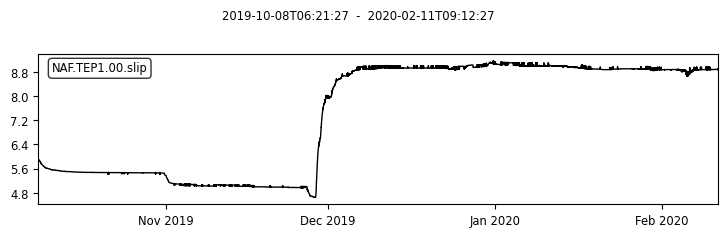

TWR1 63
no author
no file found
WKR1 64
PARK
['Daily_measurements', 'Manual_measurements', 'WKR1_10.0mins']
Key: WKR1_10.0mins
['Slip_WKR1_10.0mins', 'Time_WKR1_10.0mins']
WKR1_10T
2024-10-09T18:50:00.000000Z


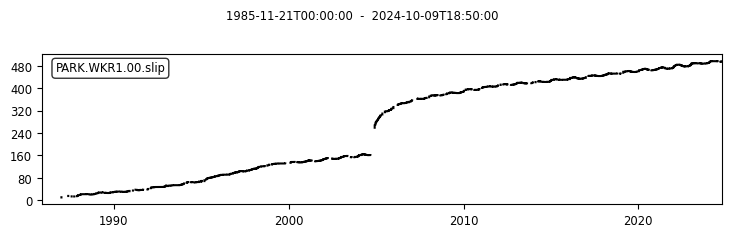

WSZ1 65
NAF
['Temperature', 'WSZ1_1.0mins', 'WSZ1_5.0mins']
Key: WSZ1_1.0mins
['Slip_WSZ1_1.0mins', 'Time_WSZ1_1.0mins']
WSZ1_1T
2023-06-07T12:20:26.000000Z


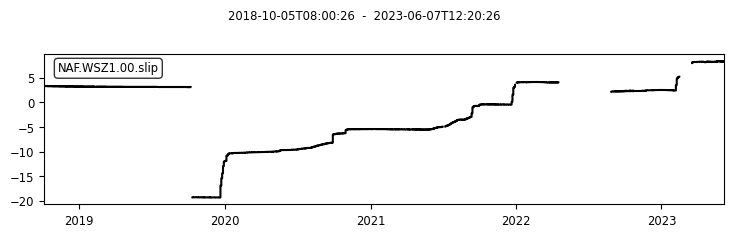

Key: WSZ1_5.0mins
['Slip_WSZ1_5.0mins', 'Time_WSZ1_5.0mins']
WSZ1_5T
2018-10-05T06:13:27.000000Z


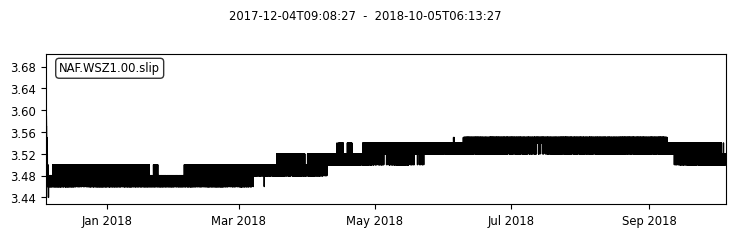

X461 66
PARK
['Daily_measurements', 'Manual_measurements', 'X461_10.0mins']
Key: X461_10.0mins
['Slip_X461_10.0mins', 'Time_X461_10.0mins']
X461_10T
2017-03-27T09:50:00.000000Z


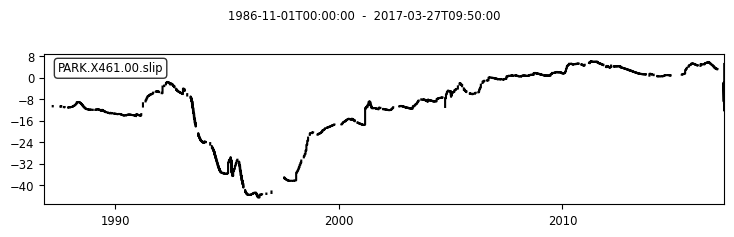

XDL2 67
no author
no file found
XFL1 68
no author
no file found
XGH1 69
PARK
['Daily_measurements', 'Manual_measurements', 'XGH1_10.0mins']
Key: XGH1_10.0mins
['Slip_XGH1_10.0mins', 'Time_XGH1_10.0mins']
XGH1_10T
2022-06-28T09:10:00.000000Z


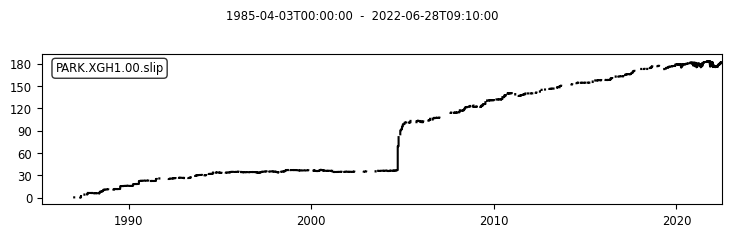

XHR1 70
HOL
['Manual_measurements', 'XHR1_10.0mins']
Key: XHR1_10.0mins
['Slip_XHR1_10.0mins', 'Time_XHR1_10.0mins']
XHR1_10T
1986-12-05T23:50:00.000000Z


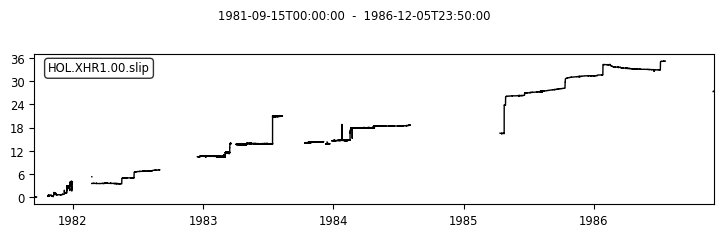

XHR2 71
HOL
['Daily_measurements', 'Manual_measurements', 'XHR2_10.0mins']
Key: XHR2_10.0mins
['Slip_XHR2_10.0mins', 'Time_XHR2_10.0mins']
XHR2_10T
2005-06-27T04:50:00.000000Z


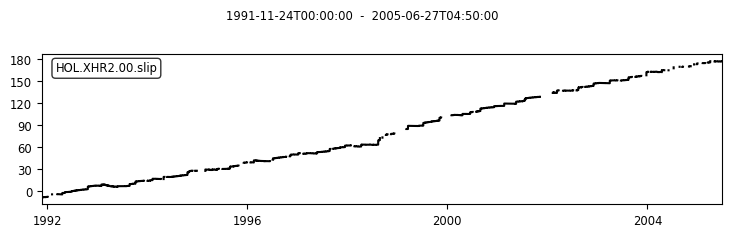

XHR3 72
HOL
['Manual_measurements', 'XHR3_1.0mins', 'XHR3_10.0mins']
Key: XHR3_1.0mins
['Slip_XHR3_1.0mins', 'Time_XHR3_1.0mins']
XHR3_1T
2024-10-09T19:27:00.000000Z


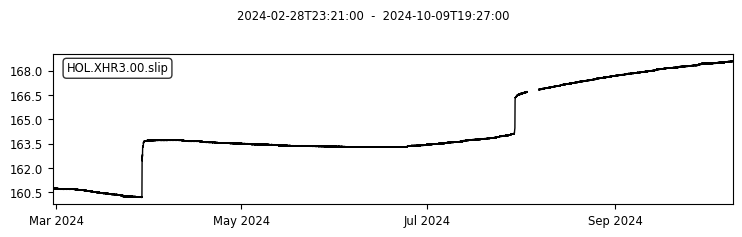

Key: XHR3_10.0mins
['Slip_XHR3_10.0mins', 'Time_XHR3_10.0mins']
XHR3_10T
2024-02-28T22:20:00.000000Z


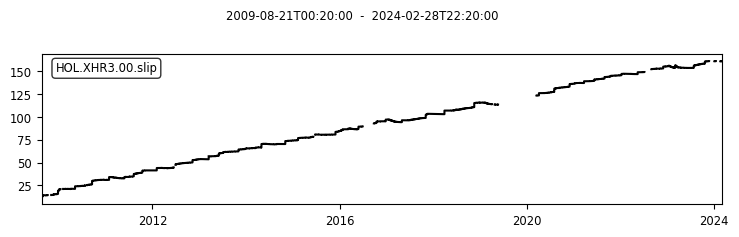

XHSW 73
PARK
['Daily_measurements', 'Manual_measurements', 'XHSW_10.0mins']
Key: XHSW_10.0mins
['Slip_XHSW_10.0mins', 'Time_XHSW_10.0mins']
XHSW_10T
2010-05-18T17:10:00.000000Z


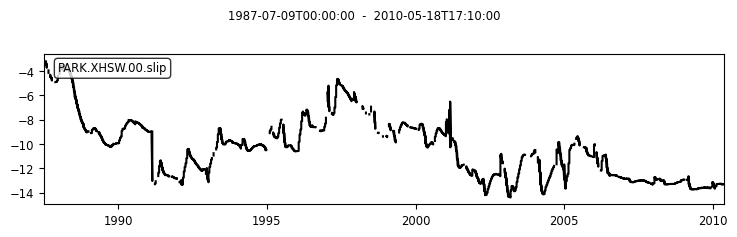

XMBC 74
PARK
['Daily_measurements', 'Manual_measurements', 'XMBC_10.0mins']
Key: XMBC_10.0mins
['Slip_XMBC_10.0mins', 'Time_XMBC_10.0mins']
XMBC_10T
2011-01-11T00:40:00.000000Z


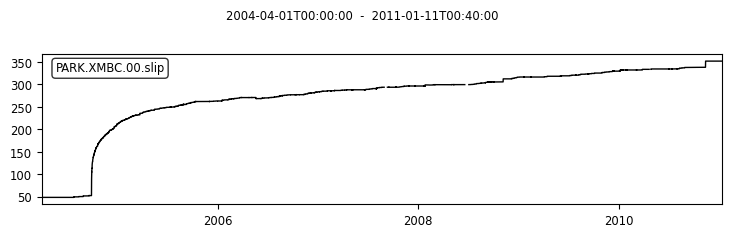

XMD1 75
PARK
['Daily_measurements', 'Manual_measurements', 'XMD1_10.0mins']
Key: XMD1_10.0mins
['Slip_XMD1_10.0mins', 'Time_XMD1_10.0mins']
XMD1_10T
2024-10-09T19:00:00.000000Z


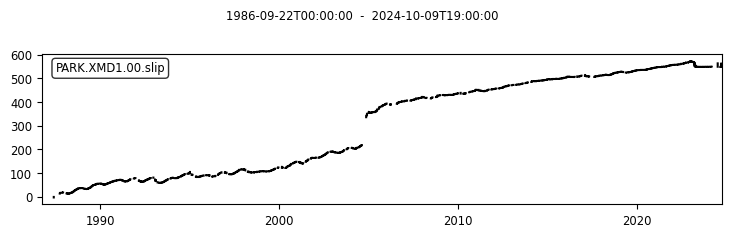

XMM1 76
PARK
['Daily_measurements', 'Manual_measurements', 'XMM1_10.0mins']
Key: XMM1_10.0mins
['Slip_XMM1_10.0mins', 'Time_XMM1_10.0mins']
XMM1_10T
2023-04-26T07:50:00.000000Z


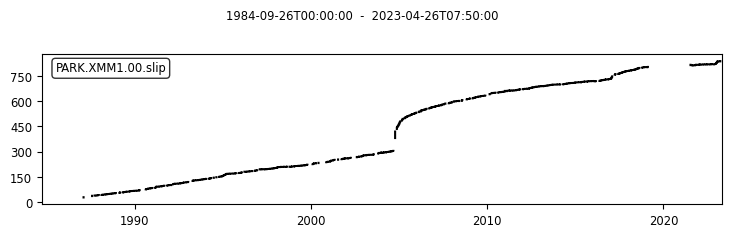

XMP1 77
no author
no file found
XMP2 78
no author
no file found
XMR1 79
HOL
['Daily_measurements', 'Manual_measurements', 'XMR1_1.0mins', 'XMR1_10.0mins']
Key: XMR1_1.0mins
['Slip_XMR1_1.0mins', 'Time_XMR1_1.0mins']
XMR1_1T
2024-10-09T19:37:00.000000Z


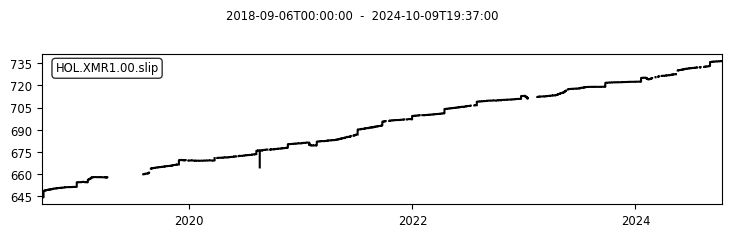

Key: XMR1_10.0mins
['Slip_XMR1_10.0mins', 'Time_XMR1_10.0mins']
XMR1_10T
2014-03-11T20:30:00.000000Z


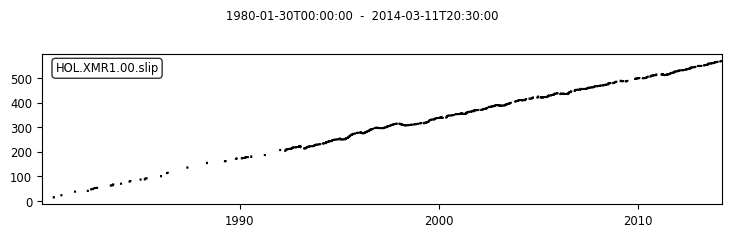

XPH1 80
no author
no file found
XPK1 81
PARK
['Daily_measurements', 'Manual_measurements', 'XPK1_10.0mins']
Key: XPK1_10.0mins
['Slip_XPK1_10.0mins', 'Time_XPK1_10.0mins']
XPK1_10T
2004-09-28T17:09:59.000000Z


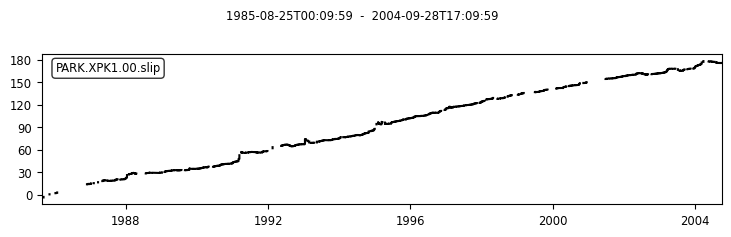

XPK2 82
PARK
['Daily_measurements', 'Manual_measurements', 'XPK2_10.0mins']
Key: XPK2_10.0mins
['Slip_XPK2_10.0mins', 'Time_XPK2_10.0mins']
XPK2_10T
2023-03-08T23:00:00.000000Z


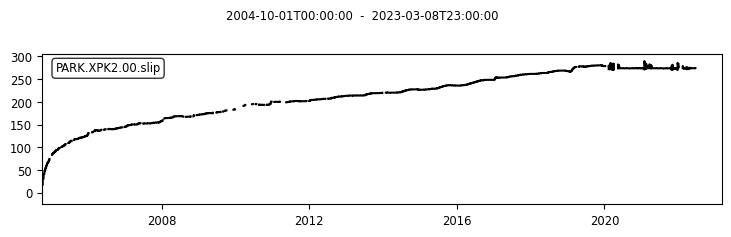

XRSW 83
PARK
['Daily_measurements', 'Manual_measurements', 'XRSW_10.0mins']
Key: XRSW_10.0mins
['Slip_XRSW_10.0mins', 'Time_XRSW_10.0mins']
XRSW_10T
2005-09-23T00:00:00.000000Z


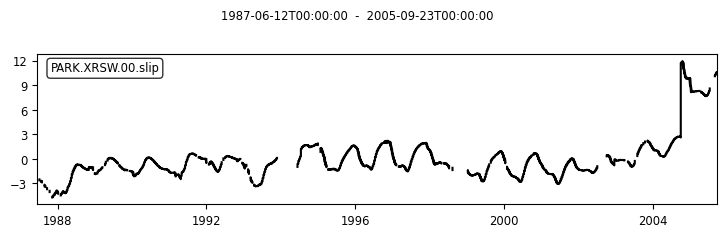

XSC1 84
PARK
['Daily_measurements', 'Manual_measurements', 'XSC1_10.0mins']
Key: XSC1_10.0mins
['Slip_XSC1_10.0mins', 'Time_XSC1_10.0mins']
XSC1_10T
2022-11-15T00:00:00.000000Z


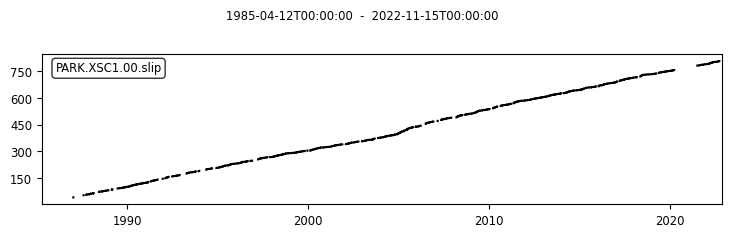

XSH1 85
CAL
['Daily_measurements', 'Manual_measurements', 'XSH1_1.0mins']
Key: XSH1_1.0mins
['Slip_XSH1_1.0mins', 'Time_XSH1_1.0mins']
XSH1_1T
2024-10-09T18:37:59.000000Z


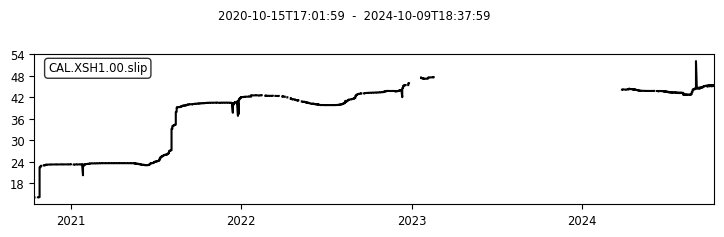

XSJ2 86
HOL
['Daily_measurements', 'Manual_measurements', 'XSJ2_10.0mins']
Key: XSJ2_10.0mins
['Slip_XSJ2_10.0mins', 'Time_XSJ2_10.0mins']
XSJ2_10T
2006-07-05T01:30:00.000000Z


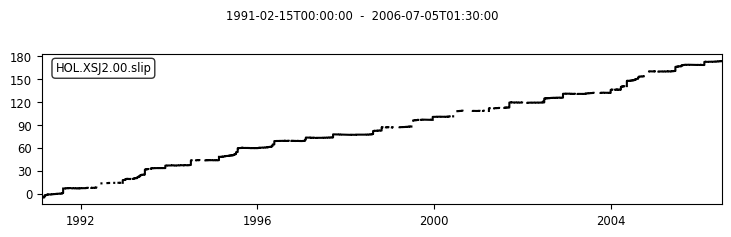

XSJ3 87
HOL
['Daily_measurements', 'Manual_measurements', 'XSJ3_10.0mins']
Key: XSJ3_10.0mins
['Slip_XSJ3_10.0mins', 'Time_XSJ3_10.0mins']
XSJ3_10T
2016-12-08T18:09:59.000000Z


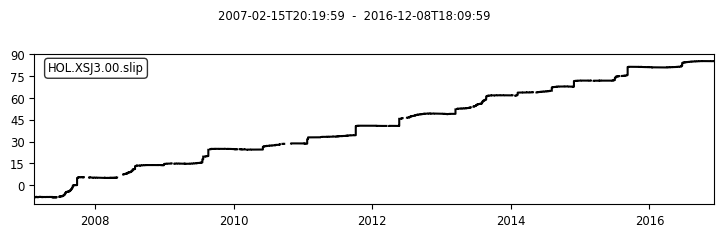

XTA1 88
PARK
['Daily_measurements', 'Manual_measurements', 'XTA1_10.0mins']
Key: XTA1_10.0mins
['Slip_XTA1_10.0mins', 'Time_XTA1_10.0mins']
XTA1_10T
2024-10-09T18:50:00.000000Z


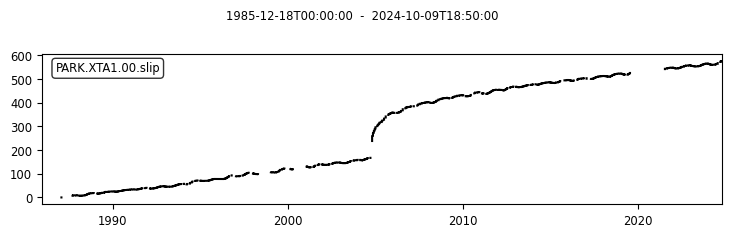

XVA1 89
PARK
['Daily_measurements', 'Manual_measurements', 'XVA1_10.0mins']
Key: XVA1_10.0mins
['Slip_XVA1_10.0mins', 'Time_XVA1_10.0mins']
XVA1_10T
2017-10-23T22:10:00.000000Z


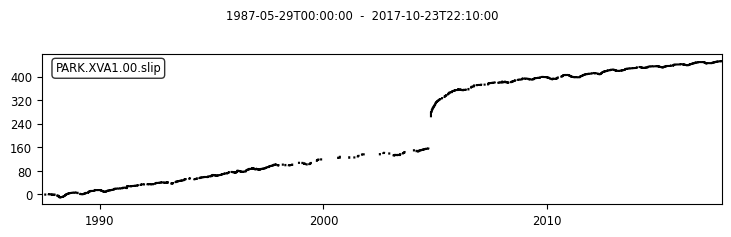

YZE1 90
EAF
['Temperature', 'YZE1_1.0mins']
Key: YZE1_1.0mins
['Slip_YZE1_1.0mins', 'Time_YZE1_1.0mins']
YZE1_1T
2024-05-26T12:59:07.000000Z


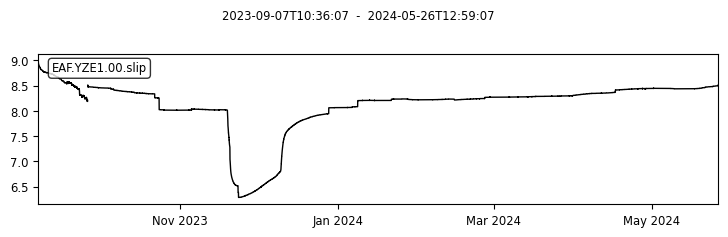

YZW1 91
EAF
['Temperature', 'YZW1_1.0mins']
Key: YZW1_1.0mins
['Slip_YZW1_1.0mins', 'Time_YZW1_1.0mins']
YZW1_1T
2024-05-26T14:10:37.000000Z


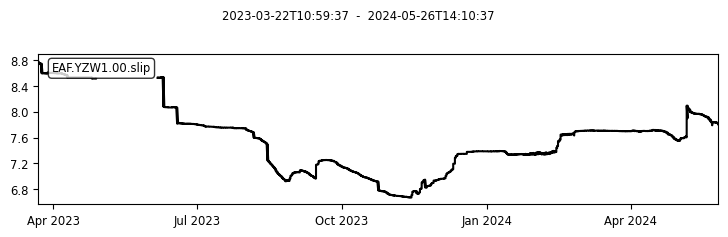

In [35]:
for i in range(len(files)):
    abbreviation = files[i][:4]
    if abbreviation[2]=='.':
        abbreviation = abbreviation[:2]
    print(abbreviation,i)
    try:
        # Open the HDF5 file in read mode
        with h5py.File('../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation), 'r') as f:
            try:
                author = f.attrs['author']
            except KeyError:
                print('no author')
            network = f.attrs['network']
            print(network)
            latitude = f.attrs['latitude']
            longitude = f.attrs['longitude']
            depth = f.attrs['depth']
            length = f.attrs['length'] 
            obliquity = f.attrs['obliquity']
            # Loop through each key in the file
            keys = list(f.keys())
            print(keys)
            
            for key in f.keys():
                if key not in ['Temperature','Temperature_1T','Temperature_5T','Daily_measurements','Manual_measurements','Orthogonal']:
                    print("Key:", key)
                    data = f[key]  # Access the dataset
                    data_keys = list(data.keys())
                    print(data_keys)
                    slip = data[data_keys[0]][:]
                    time =  data[data_keys[1]][:]
                    decoded_time = [byte_str.decode('utf-8') for byte_str in time]
                    decoded_time = pd.to_datetime(decoded_time)

                    smpl_rate = data.attrs['sampling_rate']   
                    time_units = data.attrs['time_units']     
                    slip_units = data.attrs['slip_units']  
                    channel = data.attrs['channel'] 
                    starttime = data.attrs['starttime'] 
                    delta = data.attrs['delta']
                    freq_chosen = frequency_dict[smpl_rate]
                    upsampled = interpolate(decoded_time,slip,freq_chosen)


                    tr = obspy.Trace(np.array(upsampled['Slip']))
                    st = obspy.Stream(tr)
                    st[0].stats.network = network
                    st[0].stats.station = abbreviation
                    st[0].stats.location = '00'
                    st[0].stats.channel = channel
                    st[0].stats.starttime = starttime
                    st[0].stats.delta = delta
                    st[0].stats['latitude'] = latitude
                    st[0].stats['longitude'] = longitude
                    st[0].stats['length'] = length
                    st[0].stats['depth'] = depth
                    st[0].stats['obliquity'] = obliquity
                    file_code = abbreviation + '_{k}'.format(k=freq_chosen)
                    
                    print(file_code)
                    print(st[0].stats.endtime)
                    tr.plot();
                    instrument = pd.DataFrame({'Network':[st[0].stats.network],'Creepmeter_abbrv':['{k}'.format(k=abbreviation)],'File_code':[file_code],
                                                'Start Time':[st[0].stats.starttime],'End Time':[st[0].stats.endtime],'Sampling rate, Hz':[st[0].stats.sampling_rate],
                                                'Sampling rate, mins':[freq_chosen],'Latitude':[latitude],'Longitude':[longitude],'Length':[length],'Depth':[depth],
                                                'Obliquity':[obliquity]})
                    
                    Creepmeter_dataframe_SAC = pd.concat([Creepmeter_dataframe_SAC,instrument],ignore_index=True)
                    
                    Creepmeter_dataframe_SAC.drop_duplicates(subset='File_code',inplace=True)
                    Creepmeter_dataframe_SAC.reset_index(inplace=True,drop=True)
                    
                    #Creepmeter_dataframe_SAC.to_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes.csv')
                    st.write('../../Data/DATA_tidied/SAC/{k}.SAC'.format(k=file_code),format='SAC')
    except:
        print('no file found')
            

In [36]:
creepmeter_list = pd.read_excel('../../Data/Creepmeter_list.xlsx')
creepmeter_list

,Network,Creepmeter_full_name,Creepmeter_abbrv,Latitude,Longitude,Length,Depth,Obliquity,Sensor Type,Rod type,...,Regular sampling mins,Daily,Manual,Temp,orthogonal,voltage,IR,ortho V,To Pick,Column1
0,EAF,Balikburnu,BAL1,37.99030,38.19900,5 m,NaN,30,NaN,NaN,...,Yes,No,No,Yes,No,No,No,No,Yes,NaN
1,CSAF,Bitterwater,BIT1,36.39800,-120.98200,18 m,cm,45,USGS standard,rod,...,No,No,Yes,No,No,No,No,No,NaN,NaN
2,PARK,Highway 46,C461,35.72400,-120.28200,NaN,NaN,30,Bilham #1,Invar,...,Yes,No,No,No,No,No,No,No,No,
3,PARK,Highway 46,C462,35.72400,-120.28200,NaN,NaN,30,LVDT,NaN,...,Yes,No,No,No,No,No,No,No,No,NaN
4,UTA,Canyonlands,CAN1,38.01980,-110.03740,7.5 m,NaN,45,NaN,NaN,...,Yes,No,No,Yes,No,No,No,No,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,PARK,Varian,XVA1,35.92200,-120.46200,30 m,1 m,30,USGS standard,wire,...,Yes,Yes,Yes,No,No,No,No,No,No,NaN
94,EAF,Yazica East,YZE1,38.17910,38.75260,20 m,NaN,30,NaN,NaN,...,Yes,No,No,Yes,No,No,No,No,Yes,NaN
95,EAF,Yazica West,YZW1,38.10860,38.73610,5 m,NaN,35,NaN,NaN,...,Yes,No,No,Yes,No,No,No,No,Yes,NaN
96,DSF,Dead Sea,DS30,31.23655,35.36525,NaN,NaN,30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
full_name = []
for i in range(len(Creepmeter_dataframe_SAC)):
    abbrv = Creepmeter_dataframe_SAC['Creepmeter_abbrv'].iloc[i]
    print(abbrv)
    instrument_df = creepmeter_list[creepmeter_list['Creepmeter_abbrv'] == abbrv]
    full_name.append(instrument_df['Creepmeter_full_name'].iloc[0])

print(full_name)
Creepmeter_dataframe_SAC['Creepmeter_full_name'] = full_name

BAL1
C461
C462
CAN1
CER1
CER1
CFW1
CFW1
CFW1
CHA1
CHE1
CHE1
CHE1
CHP1
CHP1
COZ1
COZ1
COZ1
CPP1
CPP1
CRR1
CTM1
CTM1
CTM1
CWC3
CWN1
CWN1
CWN1
DS30
DU30
DU30
DU30
DU30
ESZ1
ESZ1
FCR1
FE30
FE30
FE30
FE30
GB
GB
GD
GD
GOK1
GOZ1
GS
GS
GS
HAM1
HAS1
HAT1
INW1
INW1
IR30
IR30
ISW1
KAR1
KIR1
NS45
NS45
NS45
NS45
ORM1
PAN1
PAN1
PAS1
PAS1
PET1
PET1
QE30
QW30
R7
R7
RA
RA
RB
RB
RR45
RR45
RR45
RR45
SEL1
SH30
SH30
SIV1
SIV1
SJN1
SJN1
SJN1
SU30
SU30
SU30
SU30
SU30
TABC
TAS1
TAS1
TEP1
WKR1
WSZ1
WSZ1
X461
XGH1
XHR1
XHR2
XHR3
XHR3
XHSW
XMBC
XMD1
XMM1
XMR1
XMR1
XPK1
XPK2
XRSW
XSC1
XSH1
XSJ2
XSJ3
XTA1
XVA1
YZE1
YZW1
['Balikburnu', 'Highway 46', 'Highway 46', 'Canyonlands', 'Cerkes', 'Cerkes', 'Fremont Winery', 'Fremont Winery', 'Fremont Winery', 'Chaman', 'Cherry', 'Cherry', 'Cherry', 'Hayward Palisades St #2', 'Hayward Palisades St #2', 'Oakland Zoo', 'Oakland Zoo', 'Oakland Zoo', 'Pt Pinole', 'Pt Pinole', 'Carr Ranch', 'Temescal', 'Temescal', 'Temescal', 'Cienega Winery Central', 'Cienega Winery North', 'Cie

In [38]:
Creepmeter_dataframe_SAC

,Network,Creepmeter_abbrv,File_code,Start Time,End Time,"Sampling rate, Hz","Sampling rate, mins",Latitude,Longitude,Length,Depth,Obliquity,Creepmeter_full_name
0,EAF,BAL1,BAL1_1T,2023-03-12T10:47:55.000000Z,2023-09-05T13:14:55.000000Z,0.016667,1T,37.9903,38.1990,5 m,NaN,30,Balikburnu
1,PARK,C461,C461_10T,2004-09-29T02:20:00.000000Z,2022-06-20T12:40:00.000000Z,0.001667,10T,35.7240,-120.2820,NaN,NaN,30,Highway 46
2,PARK,C462,C462_1T,2021-08-19T19:10:11.000000Z,2024-03-22T01:05:11.000000Z,0.016667,1T,35.7240,-120.2820,NaN,NaN,30,Highway 46
3,UTA,CAN1,CAN1_30T,2012-06-12T15:33:00.000000Z,2017-06-15T08:33:00.000000Z,0.000556,30T,38.0198,-110.0374,7.5 m,NaN,45,Canyonlands
4,NAF,CER1,CER1_30S,2019-10-09T06:46:00.000000Z,2024-05-23T10:25:30.000000Z,0.033333,30S,40.8947,32.7773,20 m,NaN,29,Cerkes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,HOL,XSJ3,XSJ3_10T,2007-02-15T20:19:59.000000Z,2016-12-08T18:09:59.000000Z,0.001667,10T,36.8360,-121.5210,20 m,NaN,30,San Juan Bautista #3
121,PARK,XTA1,XTA1_10T,1985-12-18T00:00:00.000000Z,2024-10-09T18:50:00.000000Z,0.001667,10T,35.8900,-120.4270,30 m,1 m,30,Taylor Ranch
122,PARK,XVA1,XVA1_10T,1987-05-29T00:00:00.000000Z,2017-10-23T22:10:00.000000Z,0.001667,10T,35.9220,-120.4620,30 m,1 m,30,Varian
123,EAF,YZE1,YZE1_1T,2023-09-07T10:36:07.000000Z,2024-05-26T12:59:07.000000Z,0.016667,1T,38.1791,38.7526,20 m,NaN,30,Yazica East


In [39]:
Creepmeter_dataframe_SAC.to_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes_updated.csv')

In [13]:
st = obspy.read('../../Data/DATA_tidied/SAC/DU30_1T.SAC')
st[0].stats

         network: SOCAL
         station: DU30
        location: 00
         channel: slip
       starttime: 2010-01-02T16:40:00.000000Z
         endtime: 2024-02-02T20:28:36.819849Z
   sampling_rate: 0.01666666753590107
           delta: 59.99999687075631
            npts: 7407590
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 60.0, 'depmin': -12.6517, 'depmax': 8.8956, 'scale': 1.0, 'b': 0.0, 'e': 444455330.0, 'depmen': nan, 'nzyear': 2010, 'nzjday': 2, 'nzhour': 16, 'nzmin': 40, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 7407590, 'iftype': 1, 'iztype': 9, 'leven': 1, 'lpspol': 1, 'lovrok': 1, 'lcalda': 0, 'kstnm': 'DU30', 'khole': '00', 'kcmpnm': 'slip', 'knetwk': 'SOCAL'})

In [ ]:
data.keys

In [ ]:
st[0].plot()

In [237]:
with h5py.File('../../Data/DATA_tidied/HDF5/SIV1.h5', 'r+') as f:
    keys = list(f.keys())
    print(keys)
    old_group_name = 'SIV1_0.16667mins'
    new_group_name = 'SIV1_10s'
    old_dataset_name1 = 'Slip_SIV1_0.16667mins'
    new_dataset_name1 = 'Slip_SIV1_10s'
    old_dataset_name2 = 'Time_SIV1_0.16667mins'
    new_dataset_name2 = 'Time_SIV1_10s'
     # Check if the old group and dataset exist
    if old_group_name in f:
        # Create a new group
        new_group = f.create_group(new_group_name)
        #new_group = f[new_group_name]

        new_group.attrs['sampling_rate'] = f[old_group_name].attrs['sampling_rate']  # Example: 100 Hz sampling rate (10 ms interval)
        new_group.attrs['time_units'] = 'minutes'     # Time units
        new_group.attrs['slip_units'] = 'millimetres'  # Dependent variable units (e.g., for slip)
        new_group.attrs['channel'] = 'slip'
        new_group.attrs['starttime'] = f[old_group_name].attrs['starttime']
        new_group.attrs['delta'] = f[old_group_name].attrs['delta']
        # Copy the dataset from the old group to the new group
        if old_dataset_name1 in f[old_group_name]:
            data = f[old_group_name][old_dataset_name1][:]
            new_group.create_dataset(new_dataset_name1, data=data)

        
        # Copy the dataset from the old group to the new group
        if old_dataset_name2 in f[old_group_name]:
            data = f[old_group_name][old_dataset_name2][:]
            new_group.create_dataset(new_dataset_name2, data=data)

    

['SIV1_0.16667mins', 'SIV1_1.0mins', 'Temperature']


In [238]:
with h5py.File('../../Data/DATA_tidied/HDF5/SIV1.h5', 'r+') as f:
    keys = list(f.keys())
    print(keys)
    del f['SIV1_0.16667mins']
    keys = list(f.keys())
    print(keys)

['SIV1_0.16667mins', 'SIV1_1.0mins', 'SIV1_10s', 'Temperature']
['SIV1_1.0mins', 'SIV1_10s', 'Temperature']


In [249]:
with h5py.File('../../Data/DATA_tidied/HDF5/FXC1.h5', 'r+') as f:
    keys = list(f.keys())
    print(keys)
    old_group_name = 'FXC1_1.0mins'
    new_group_name = 'FCR1_1.0mins'
    old_dataset_name1 = 'Slip_FXC1_1.0mins'
    new_dataset_name1 = 'Slip_FCR1_1.0mins'
    old_dataset_name2 = 'Time_FXC1_1.0mins'
    new_dataset_name2 = 'Time_FCR1_1.0mins'
     # Check if the old group and dataset exist
    if old_group_name in f:
        # Create a new group
        new_group = f.create_group(new_group_name)
        #new_group = f[new_group_name]

        new_group.attrs['sampling_rate'] = f[old_group_name].attrs['sampling_rate']  # Example: 100 Hz sampling rate (10 ms interval)
        new_group.attrs['time_units'] = 'minutes'     # Time units
        new_group.attrs['slip_units'] = 'millimetres'  # Dependent variable units (e.g., for slip)
        new_group.attrs['channel'] = 'slip'
        new_group.attrs['starttime'] = f[old_group_name].attrs['starttime']
        new_group.attrs['delta'] = f[old_group_name].attrs['delta']
        # Copy the dataset from the old group to the new group
        if old_dataset_name1 in f[old_group_name]:
            data = f[old_group_name][old_dataset_name1][:]
            new_group.create_dataset(new_dataset_name1, data=data)

        
        # Copy the dataset from the old group to the new group
        if old_dataset_name2 in f[old_group_name]:
            data = f[old_group_name][old_dataset_name2][:]
            new_group.create_dataset(new_dataset_name2, data=data)

['FXC1_1.0mins', 'Orthogonal', 'Temperature']


In [256]:
with h5py.File('../../Data/DATA_tidied/HDF5/FCR1.h5', 'r+') as f:
    keys = list(f.keys())
    print(keys)
    del f['FXC1_1.0mins']
    keys = list(f.keys())
    print(keys)

['FCR1_1.0mins', 'FXC1_1.0mins', 'Orthogonal', 'Temperature']
['FCR1_1.0mins', 'Orthogonal', 'Temperature']


In [254]:
data

array([25.94, 25.94, 25.94, ..., 12.44, 12.41, 12.44])